#  Analyzing and Predicting Player Count Trends in Online Games

## Part 3: Model Construction

We will be utilizing a model known as SARIMAX, or Seasonal Auto-Regressive Integrated Moving Average with Exogenous Regressors. At first, we will not be using exogenous regressors, but we will be eventually incorporating our 'event' column to assess the impact of an ongoing event to our predictor of choice.  

### Modelling Goals

We wish to predict 3 separate things:

1. Number of players at a given time in the future
2. Player growth over a given period
3. Player growth at a given time.

### Modelling Process for SARIMA and SARIMAX

1. Transform Data
    - Outlier Removal
    - Discontinuity
2. Determine Seasonality
    - Spectral Analysis
3. Stationarity
    - ACF & PACF Analysis
4. Model Construction
5. Model Comparison

### Modelling Process for Our Data

We have to ask what exact model we want to construct. Would we want a model that is built on a single game and can only preedict that one game? Or should we build a model that takes an amalgamization of all games, and build a model based upon that? Or perhaps making a model based upon our control dataframe, Team Fortress 2, and seeing how this model performs on other games. 

1. Basic Modelling
    - CSGO
    - DOTA 2
    - Rocket League
    - Team Fortress 2
2. Amalgamized Modelling
    - Amalgamization Technique
    - Modelling
    - Testing


In [61]:
# we import the necessary libraries


from scipy.stats import boxcox as bc
import scipy.stats
import itertools
import statistics as stats
from fsds.imports import * 
from datetime import datetime
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

## Data Retreival

In [62]:
# we import our dataframes

csgo = pd.read_csv('data/Clean/csgo.csv', parse_dates = ['DateTime'], index_col = 'DateTime')
dota = pd.read_csv('data/Clean/dota.csv', parse_dates = ['DateTime'], index_col = 'DateTime')
rl = pd.read_csv('data/Clean/rl.csv', parse_dates = ['DateTime'], index_col = 'DateTime')
tf = pd.read_csv('data/Clean/tf.csv', parse_dates = ['DateTime'], index_col = 'DateTime')

raw_ls = [csgo, dota, rl, tf]

labels = ['CS:GO', "DOTA 2", 'Rocket League', 'Team Fortress 2']

ls = raw_ls

ls[0].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2195 entries, 2015-01-01 to 2021-01-03
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    2195 non-null   int64  
 1   players       2195 non-null   int64  
 2   viewers       2195 non-null   int64  
 3   event         2195 non-null   float64
 4   %chg_players  2146 non-null   float64
 5   %chg_viewers  1998 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 120.0 KB


In [63]:
# we also need to drop unnecessary columns

ls = list(map(lambda df: df.drop(columns = ['Unnamed: 0']), ls))

In [64]:
ls[0]

players  viewers  event  %chg_players  %chg_viewers
DateTime                                                       
2015-01-01   443188        0    0.0           NaN           NaN
2015-01-02   383943        0    0.0     -0.133679           NaN
2015-01-03   398639        0    0.0      0.038277           NaN
2015-01-04   389040        0    0.0     -0.024079           NaN
2015-01-05   376364        0    0.0     -0.032583           NaN
...             ...      ...    ...           ...           ...
2020-12-30  1056057    77815    0.0      0.021949     -0.075634
2020-12-31   982583    60120    0.0     -0.069574     -0.227398
2021-01-01  1020715    91532    0.0      0.038808      0.522488
2021-01-02  1079804    93678    0.0      0.057890      0.023445
2021-01-03  1067795    94130    0.0     -0.011121      0.004825

[2195 rows x 5 columns]

## 1. Basic Modelling

### a. Preparation

#### Transformations

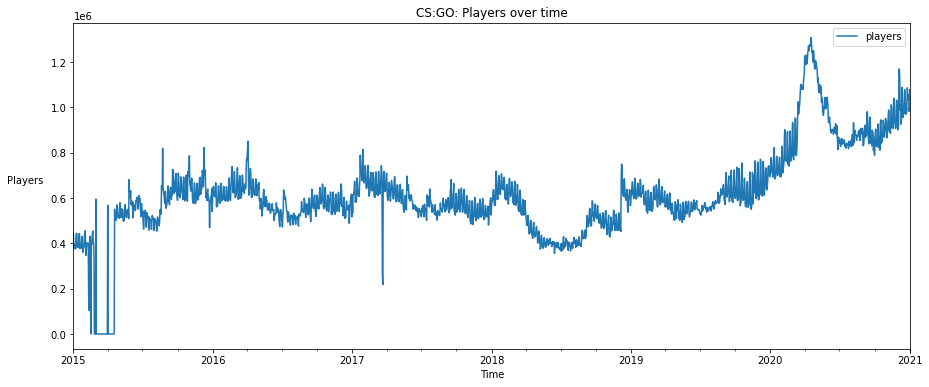

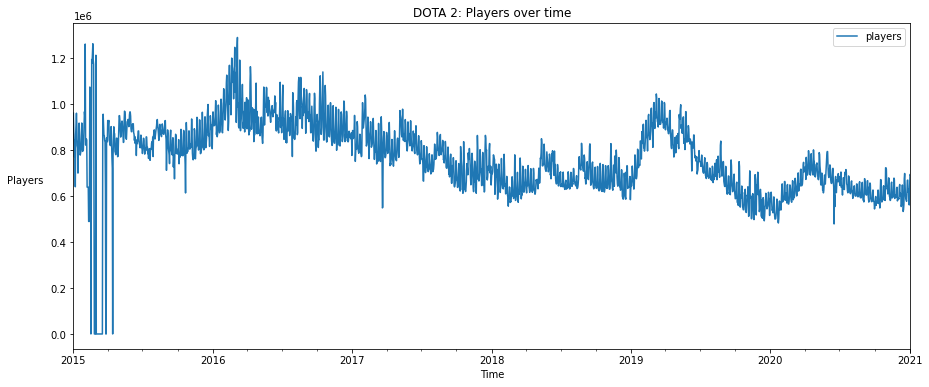

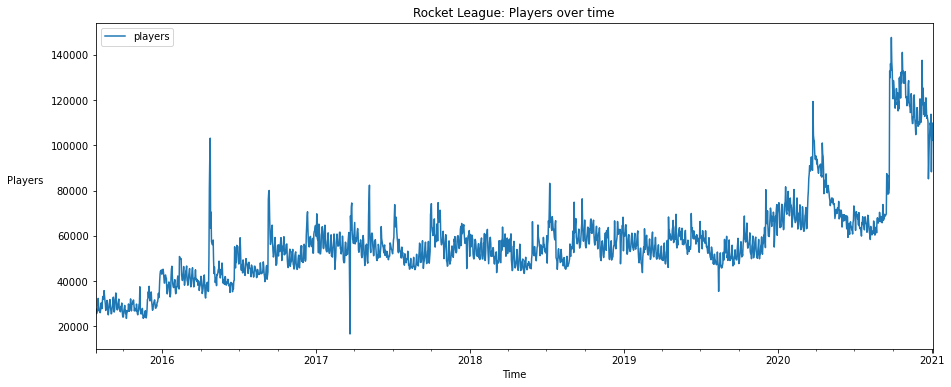

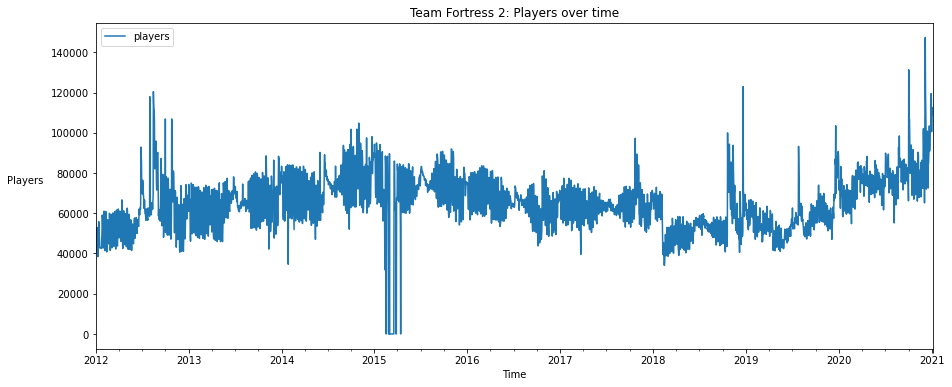

In [65]:
# we need to transform data before we even decide on our predictor column. Let's inspect players over time first. 


for i, df in enumerate(ls):
    df.plot(y = 'players', figsize = (15,6), title = labels[i]+": Players over time", xlabel = 'Time')
    plt.ylabel('Players', rotation = 0, labelpad = 25)
    plt.legend()
    plt.show()
    
    

In [66]:
# we handle discontinuities

ls = list(map(lambda df: df['players'].replace(to_replace = 0, method = 'bfill'), ls))


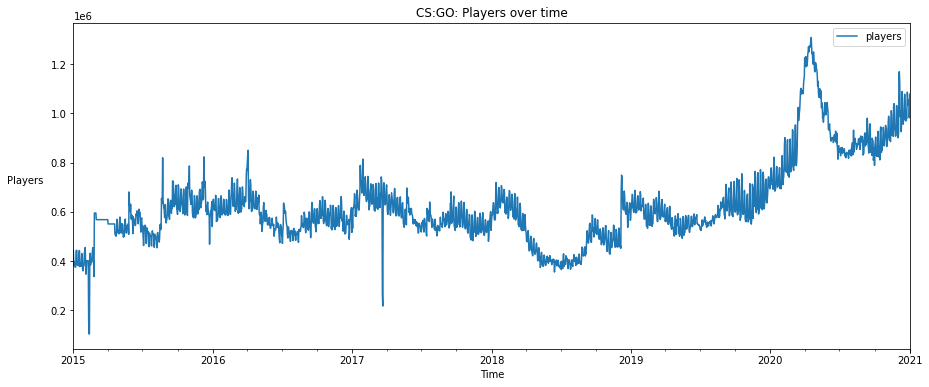

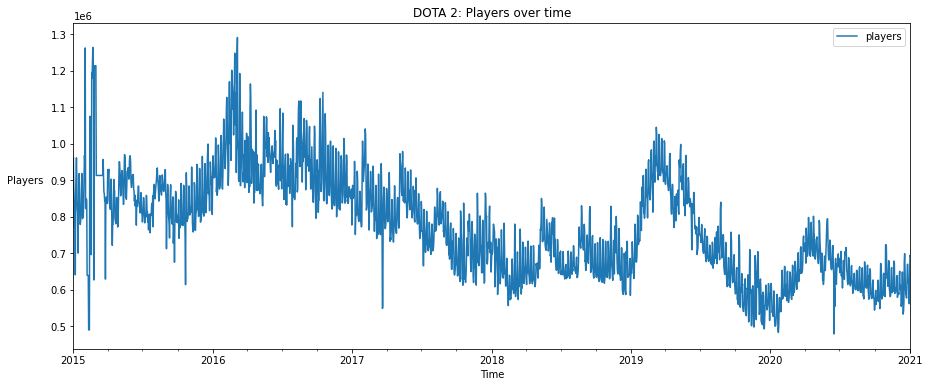

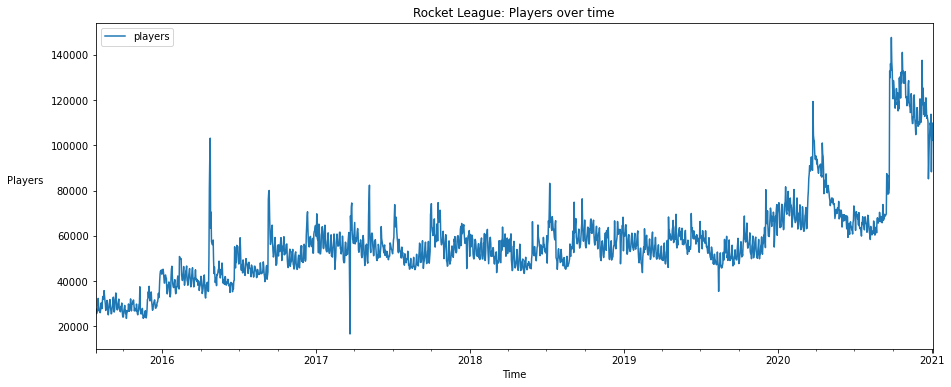

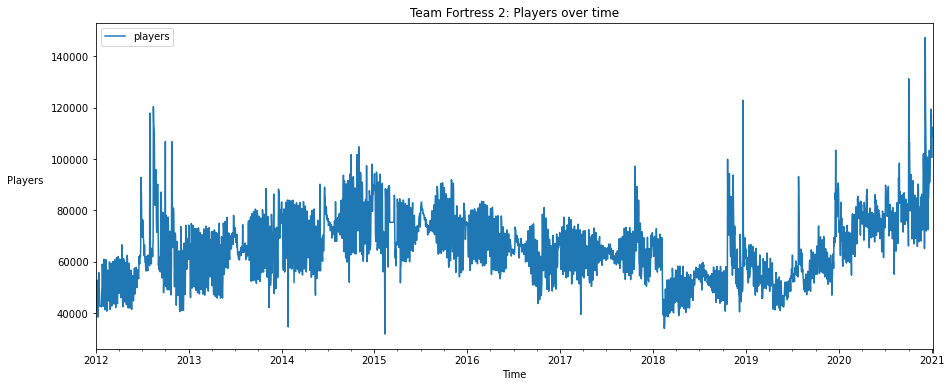

In [67]:
# and inspect to ensure this was successful

for i, df in enumerate(ls):
    df.plot(y = 'players', figsize = (15,6), title = labels[i]+": Players over time", xlabel = 'Time')
    plt.ylabel('Players', rotation = 0, labelpad = 25)
    plt.legend()
    plt.show()

In [72]:
# all of these games had major changes in number of players directly after their release, leading us to 
# model only player data a sufficient time after release. 

start_dates = [ "2016-01-01",
              "2016-01-01",
              "2016-01-01",
              "2013-01-01"]

trimmed_df_list = []

for i in range(0, 4):
    trimmed = ls[i][start_dates[i]:]
    trimmed_df_list.append(trimmed)
    
ls_trimmed = trimmed_df_list
ls = trimmed_df_list    

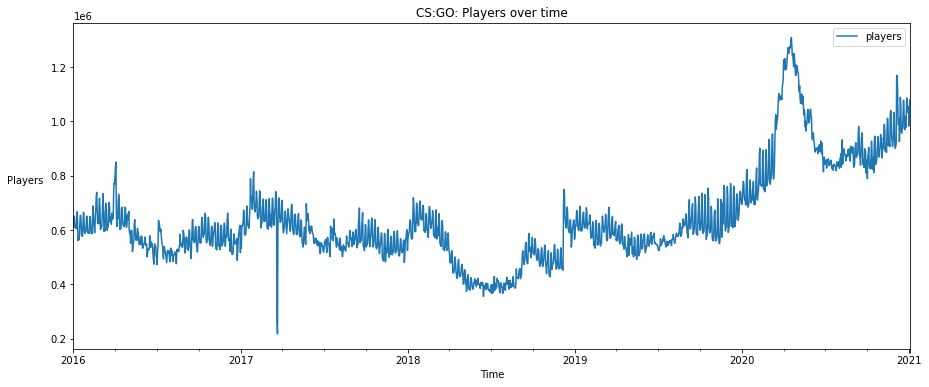

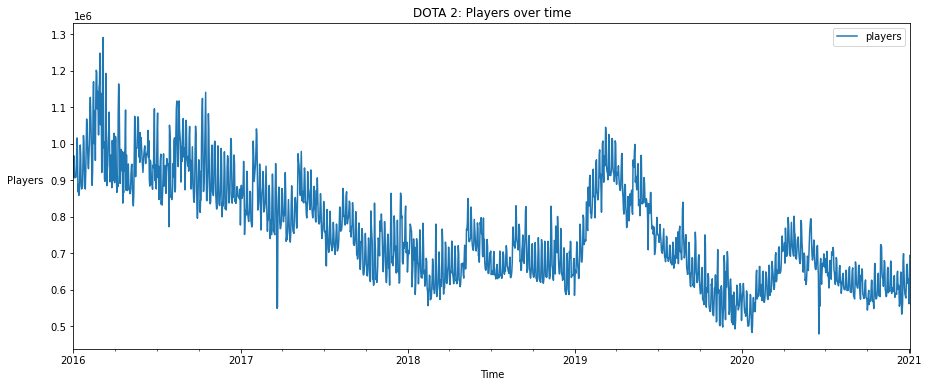

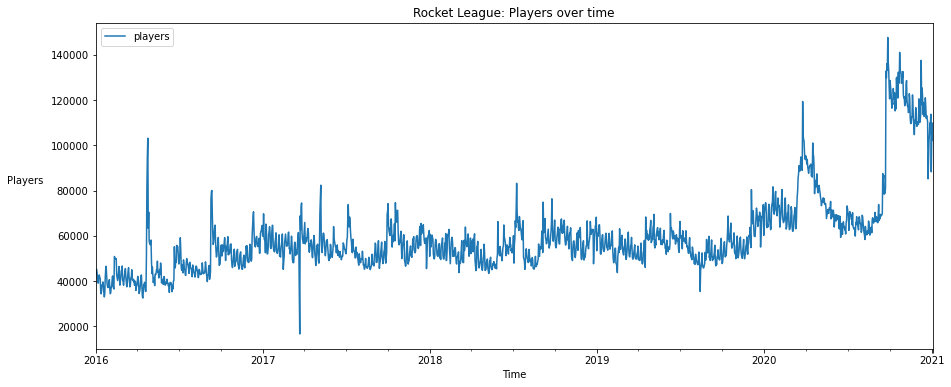

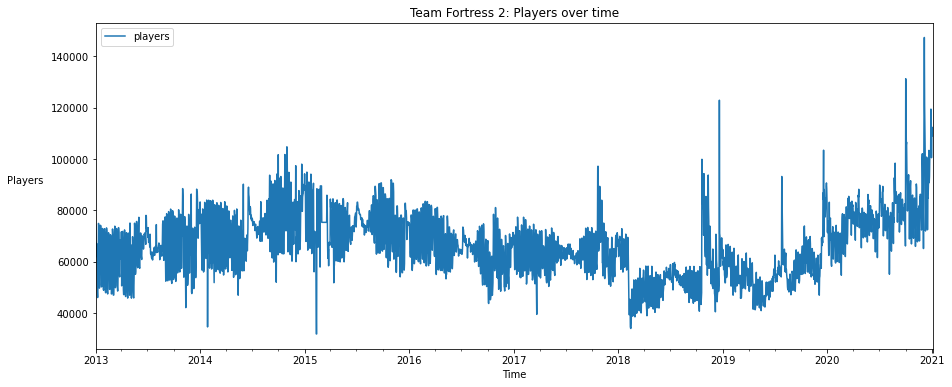

In [73]:
# we inspect our trimmed data

for i, df in enumerate(ls):
    df.plot(y = 'players', figsize = (15,6), title = labels[i]+": Players over time", xlabel = 'Time')
    plt.ylabel('Players', rotation = 0, labelpad = 25)
    plt.legend()
    plt.show()

Looking much better, but we have more work to complete before this can be modelled. 
#### Stationarity

In [70]:
# we visualize our mean player count over time. If this plot has a trend, our data is not stationary. 

for i, df in enumerate(ls):
    
    df['roll_mean'] = df['players'].rolling(window = 3).mean()
    
    df.plot(y = 'roll_mean', label = 'Average Weekly Player Count, '+ labels(i))

KeyError: 'players'

In [71]:
ls[0]

DateTime
2016-01-01     611343
2016-01-02     639407
2016-01-03     651264
2016-01-04     617618
2016-01-05     609398
               ...   
2020-12-30    1056057
2020-12-31     982583
2021-01-01    1020715
2021-01-02    1079804
2021-01-03    1067795
Name: players, Length: 1830, dtype: int64

None of our games have stationary data, and we can address this in multiple ways. We can complete data transformations such as log transformations, rolling mean transformations, or differencing.

#### Log Tranformation

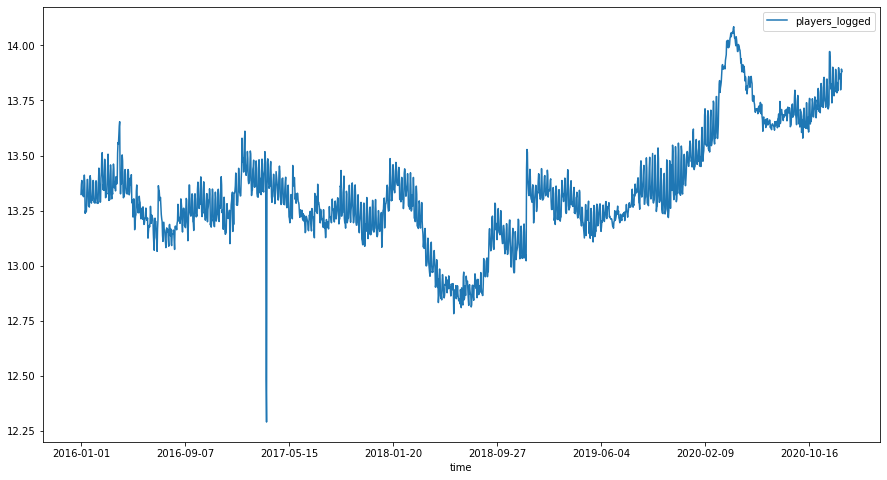

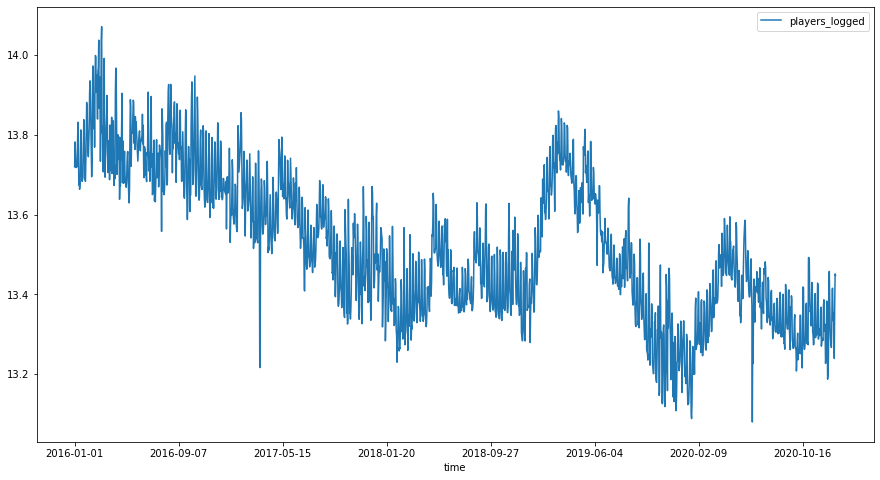

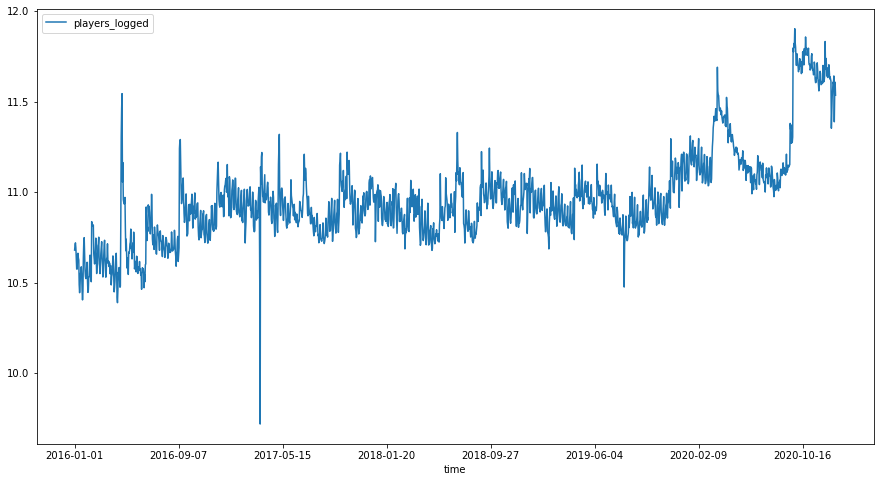

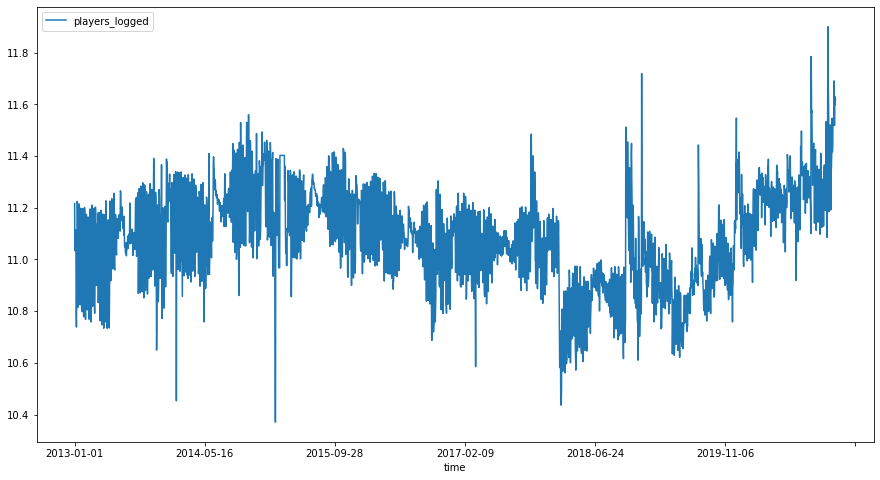

In [13]:
for df in ls:
    df['players_logged'] = np.log(df['players'])
    df_plot = pd.DataFrame(df['players_logged'])
    
    df_plot.plot(label = "# of Players Logged", figsize = (15, 8))
    plt.legend()
    plt.show()

#### Rolling Mean Transformations

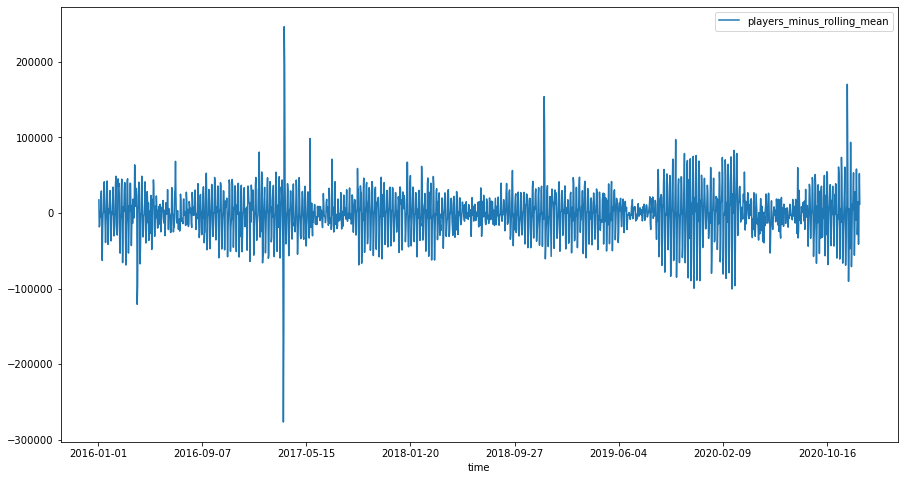

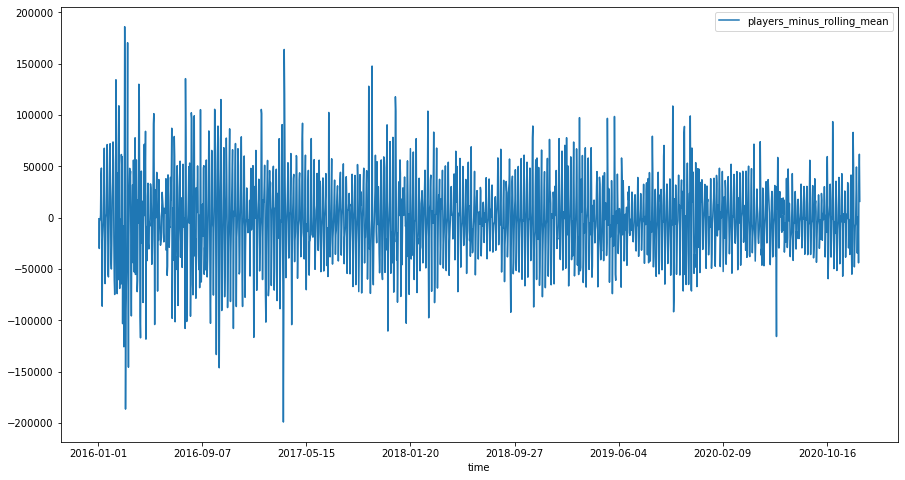

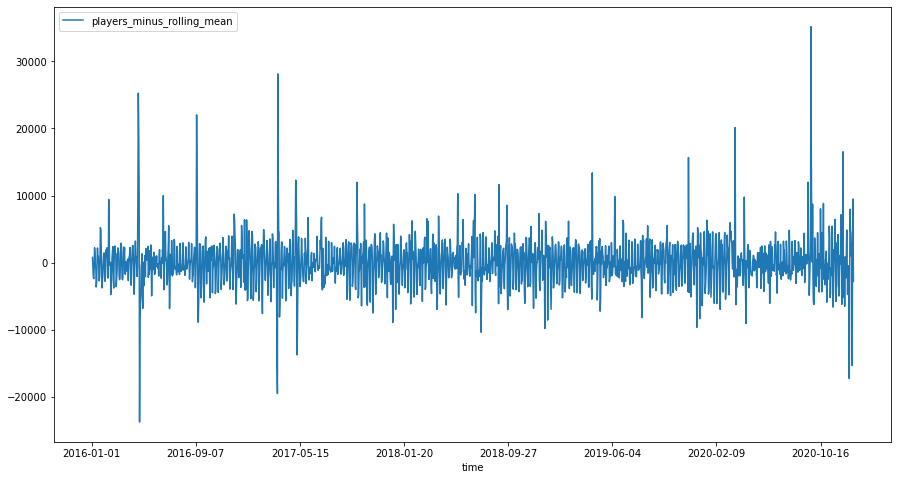

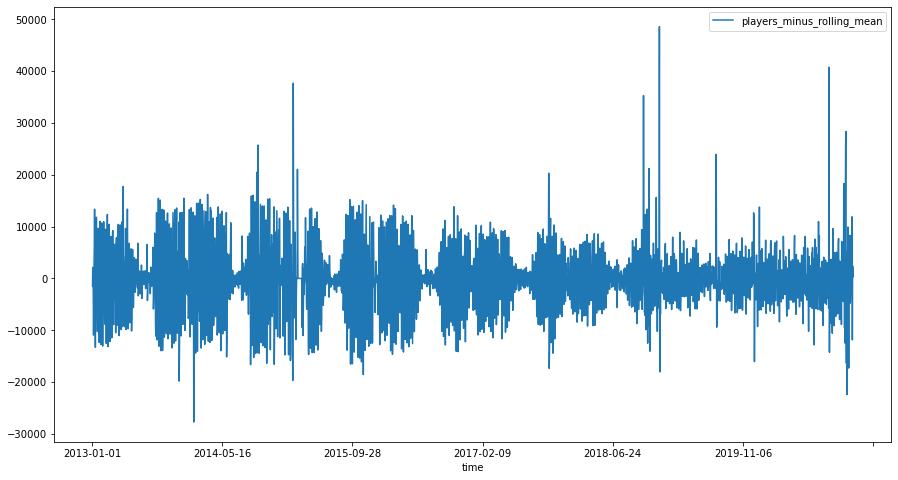

In [14]:
# we can stationize our data by subtracting the rolling mean from our 'players' column. This will force our data to be centered
# on the mean, even if the mean changes over time. 

for df in ls:
    df['players_minus_rolling_mean'] = df['players'] - df['roll_mean']
    df_plot = pd.DataFrame(df['players_minus_rolling_mean'])
    df_plot.plot(label = 'Players Centered on Rolling Average', figsize = (15, 8))
    plt.show()
    

The data looks beautifully stationary now, though there are severe outliers in some cases. We'll address this after checking how differencing will make our data look.
#### Differencing

We have already constructed a column that represents a differencing technique. Our '%chg_players' represents this difference in the form of a percentage, but let's construct the raw difference for each games player counts. 

In [15]:
# using pandas diff function

for df in ls:
    df['difference'] = df['players'].diff(periods = 1)

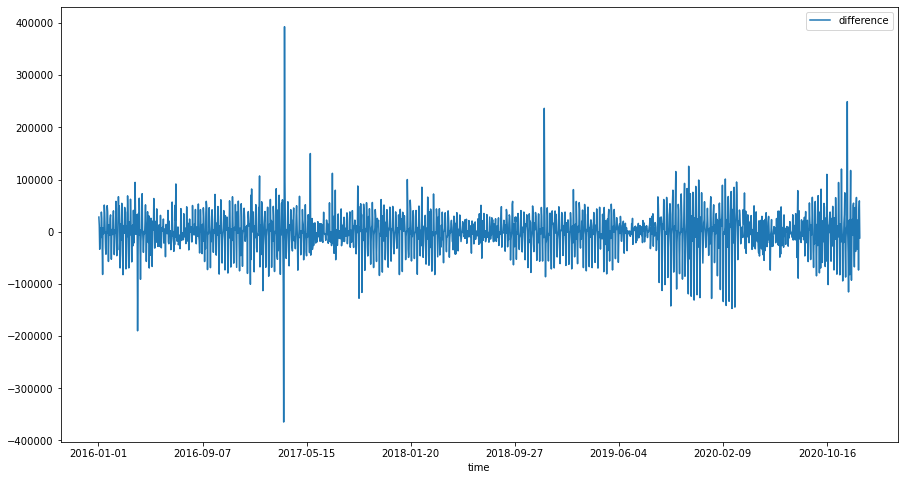

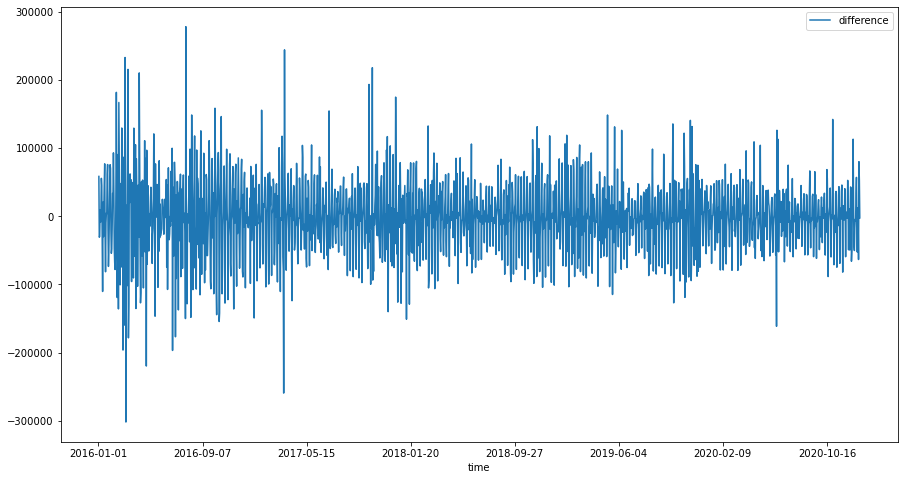

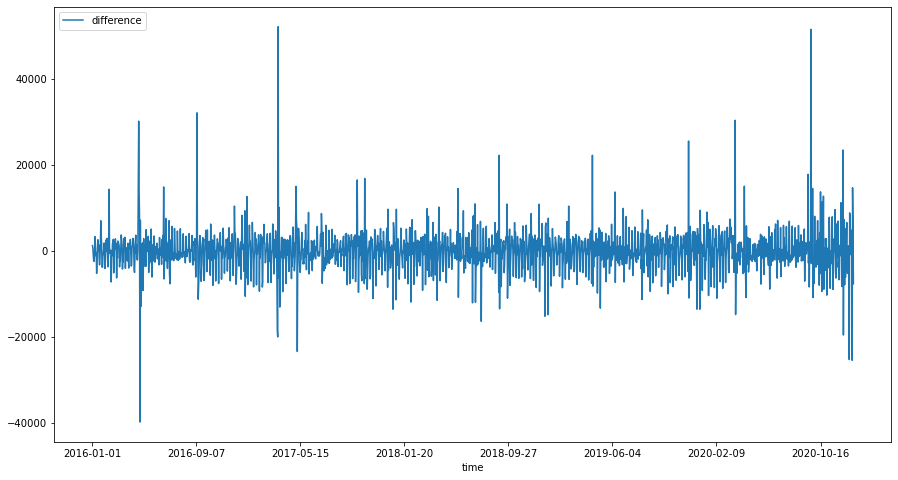

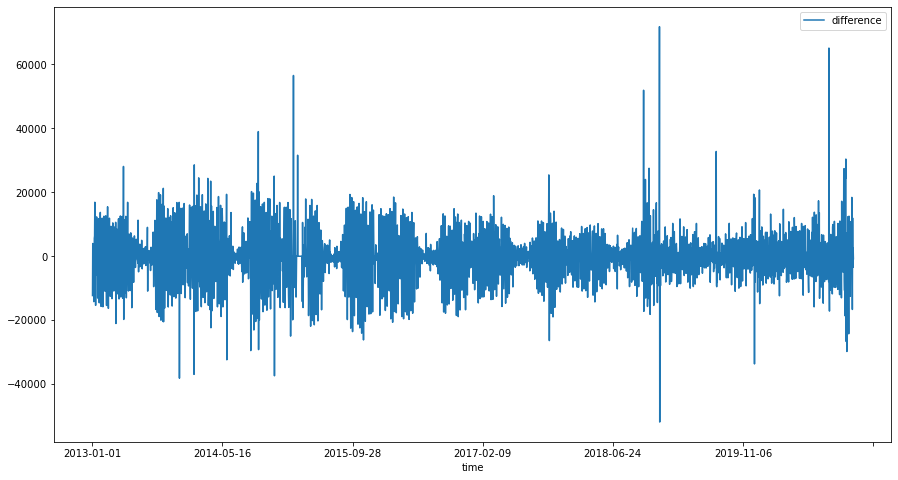

In [16]:
# basic differences

for df in ls:
    df_plot = pd.DataFrame(df['difference'])
    df_plot.plot(label = 'Differences in Players', figsize = (15, 8))
    plt.legend()
    plt.show()

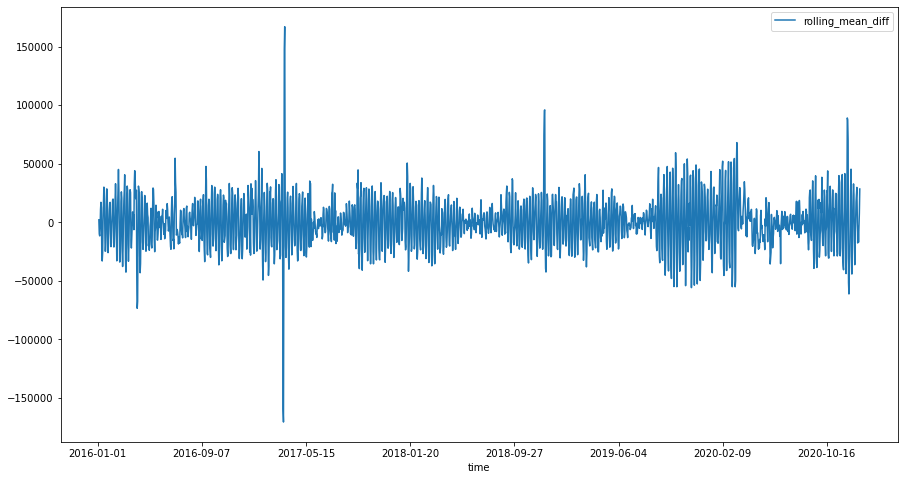

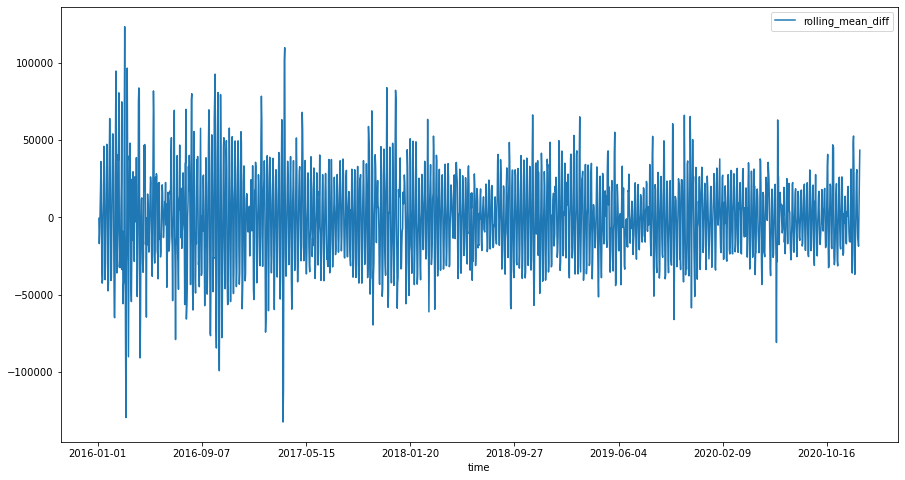

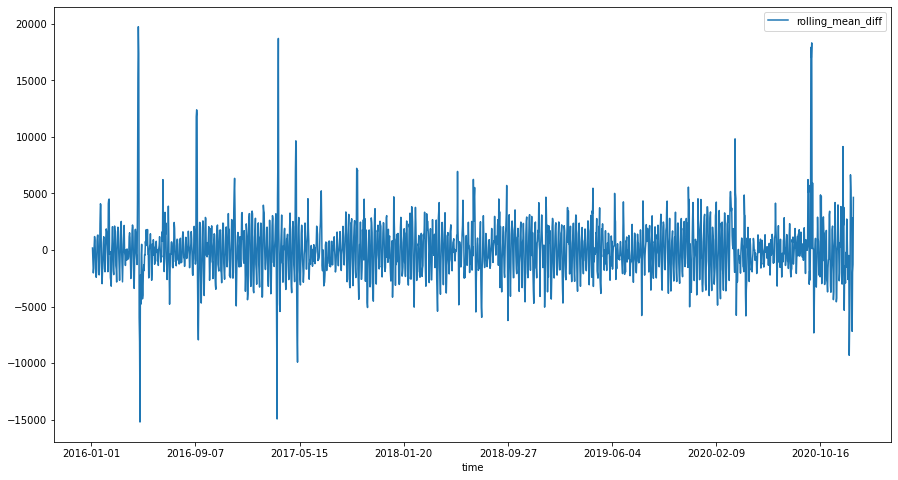

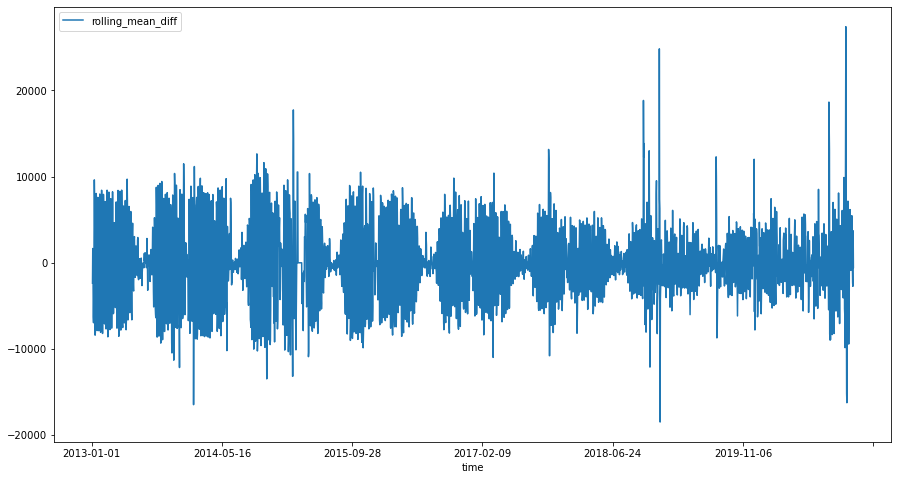

In [17]:
# differences of the rolling mean, though this would affect model interpretability

for df in ls:
    df['rolling_mean_diff'] = df['roll_mean'].diff(periods = 1)
    
    df_plot = pd.DataFrame(df['rolling_mean_diff'])
    df_plot.plot(label = 'Differences in Rolling Mean', figsize = (15,8))
    plt.legend()
    plt.show()


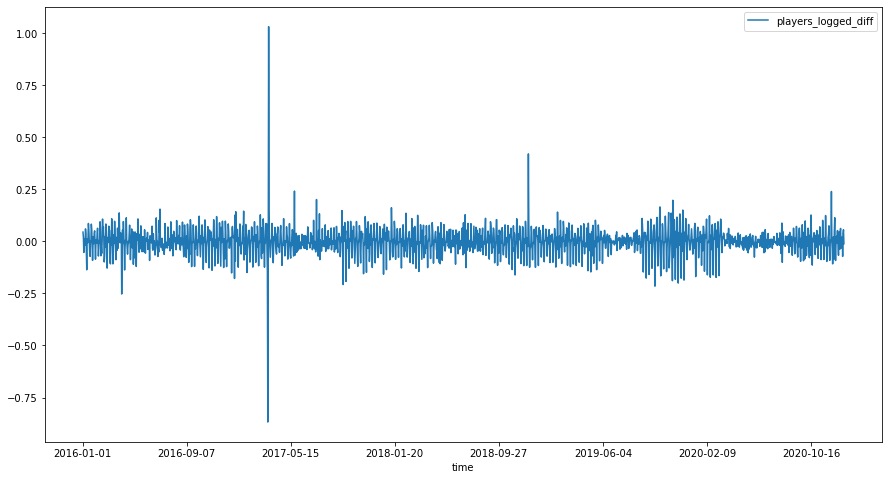

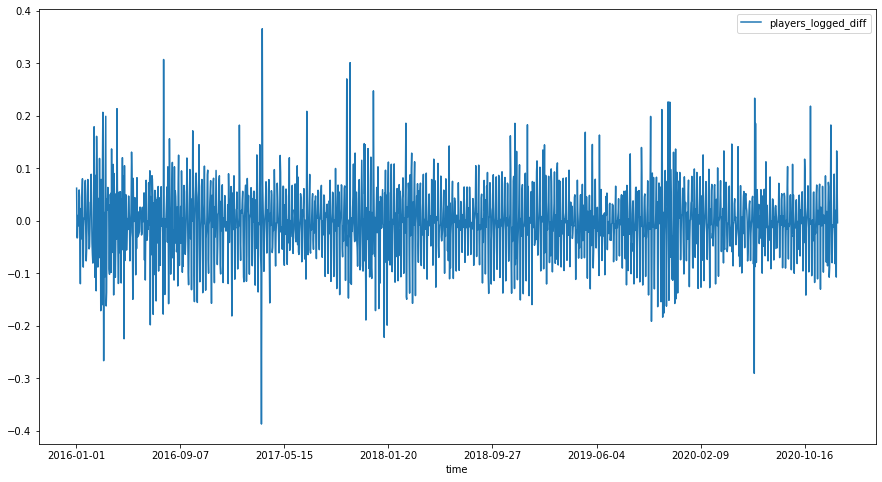

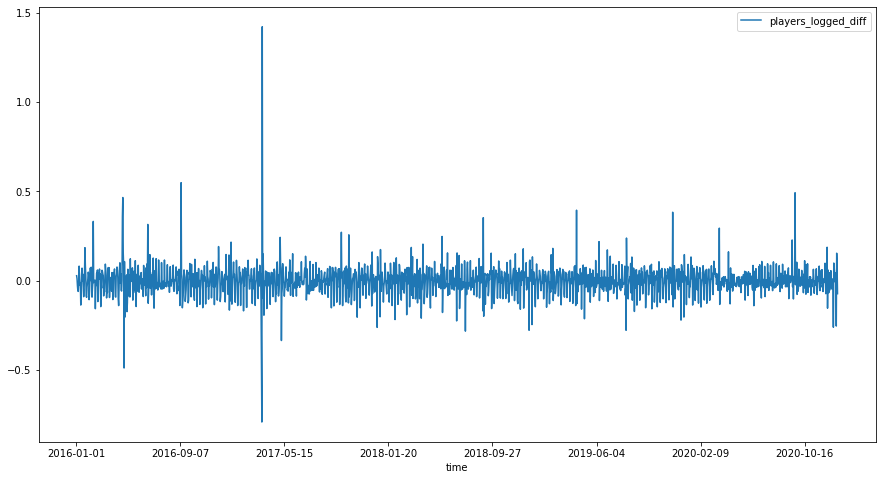

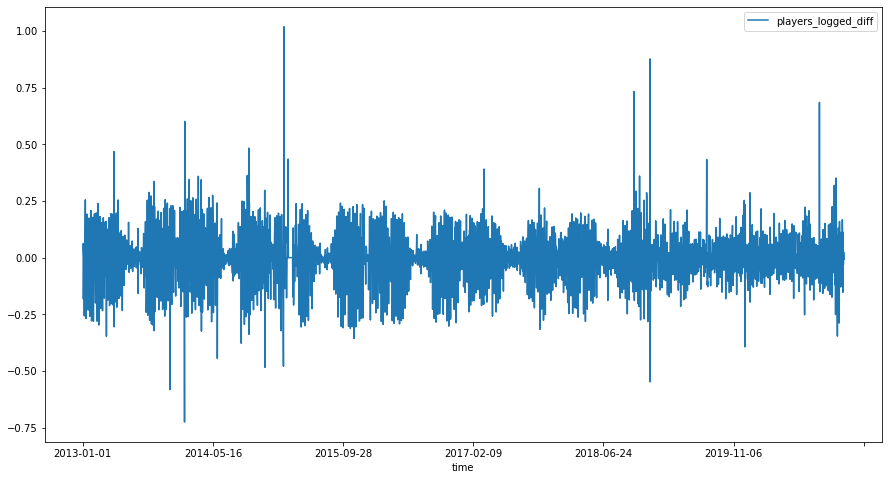

In [18]:
# differences in logged data

for df in ls:
    
    df['players_logged_diff'] = df['players_logged'].diff(periods = 1)
    df_plot = pd.DataFrame(df['players_logged_diff'])
    
    df_plot.plot(label = 'Differences in Number of Players Logged', figsize = (15, 8))

#### Outliers

We are going to deal with extreme outliers only, and we will continue on with using Logged Data, as this is normalized, on a small scale, and easily transformed back to player count.

In [19]:
# we need to keep a list of dataframes with outliers to use as a testing space.

ls_w_outliers = ls

In [20]:
ls = list(map(lambda df: df.dropna(), ls))

In [21]:
# outliers for our 'players_logged_differences'

plotting_lists = []

for df in ls:
    outlier_removed = []
    Inter_qr = scipy.stats.iqr(df['players_logged_diff'])
    mean = df['players_logged_diff'].mean()
    Q1 = df['players_logged_diff'].quantile([0.25])[0.25]
    Q3 = df['players_logged_diff'].quantile([0.75])[0.75]
    upper = Q3 + 3*Inter_qr
    lower = Q1 - 3*Inter_qr
    print(lower, upper)
    for i, val in enumerate(df['players_logged_diff']):
        if val > upper:
            outlier_removed.append(upper)
        elif val < lower:
            outlier_removed.append(lower)
        else:
            outlier_removed.append(val)
    plotting_lists.append(outlier_removed)

-0.19719134797564752 0.2014688531098061
-0.254719751483802 0.2648006319631122
-0.26011755209674803 0.2665679191113206
-0.34693047581169933 0.3571843387162348


In [22]:
for i in range(0, 4):
    ls[i]['outlier_removed_logged_diff'] = plotting_lists[i]

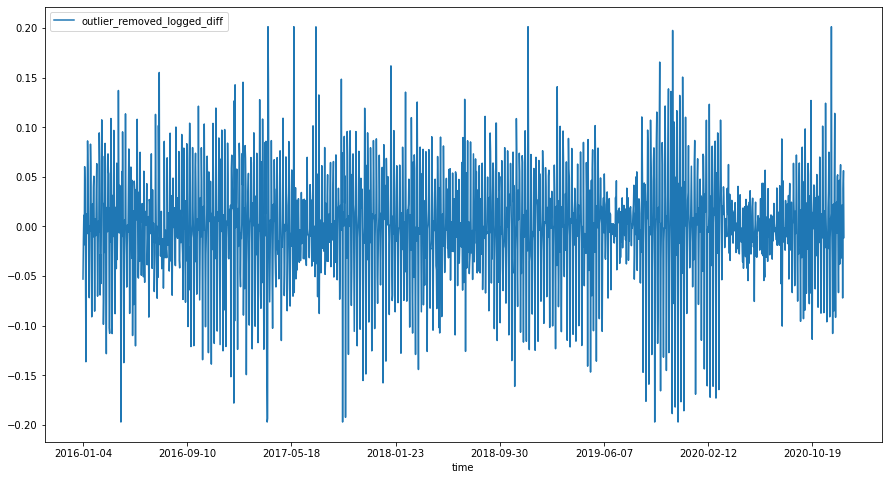

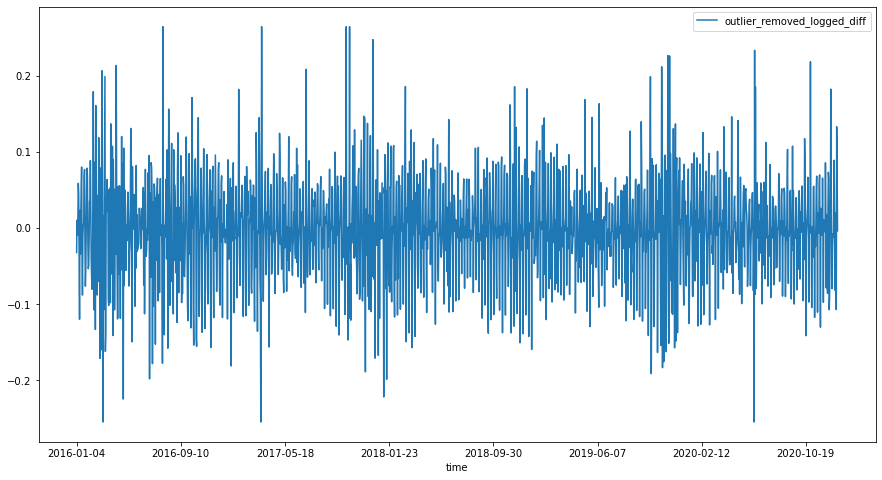

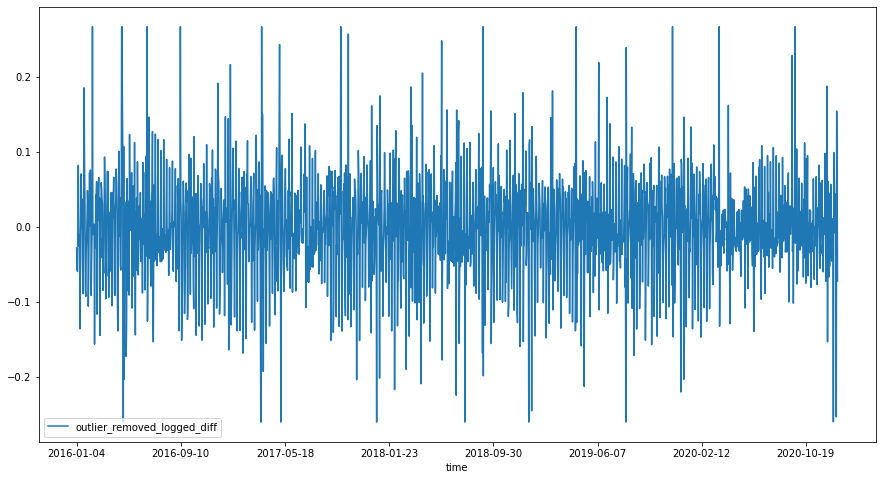

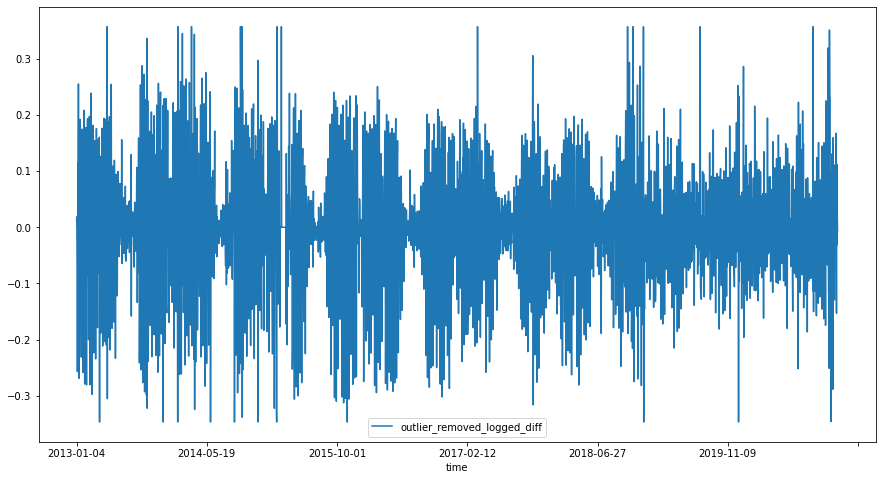

In [23]:
# let's see how this affected our data

for df in ls:
    
    df_plot = pd.DataFrame(df['outlier_removed_logged_diff'])
    
    df_plot.plot(label = "Outlier Removed Logged Differences in Player Count (ORLD)", figsize = (15, 8))
    
    plt.show()

We have beautifully stationary data, without outliers, and this is also very easy to return to our original player count!

This data is ready to be modelled. 

In [24]:
ls_prepped = ls

### b. Model Construction

We will be using a gridsearch to find the optimal model. However, we still have to manually find S, or the seasonal component of the model. 

In [25]:
# we define our predictor column and prepare it.

mod_ls = []

for df in ls:
    df_mod = pd.DataFrame()
    df_mod['ORLD'] = df['outlier_removed_logged_diff']
    mod_ls.append(df_mod)
    
training_ls = mod_ls

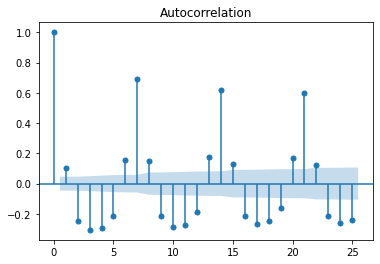

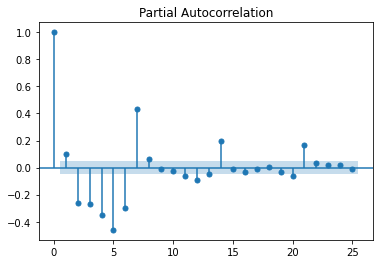

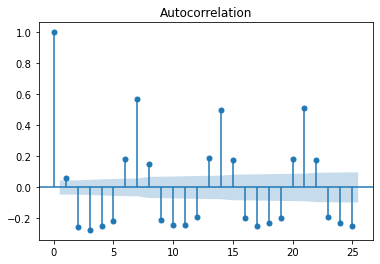

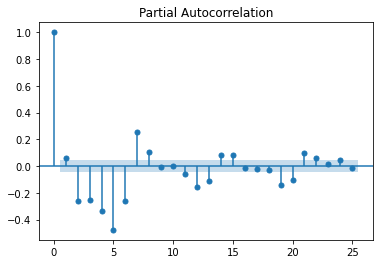

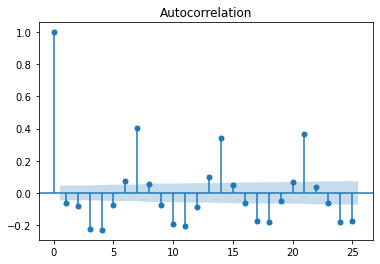

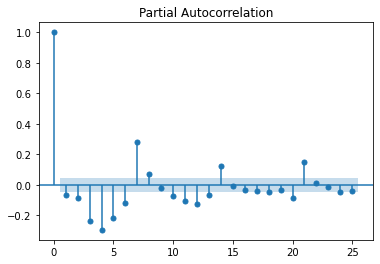

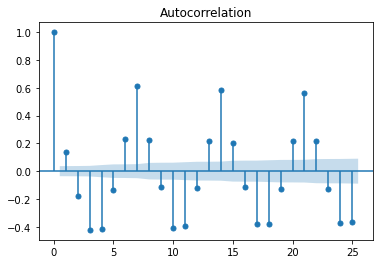

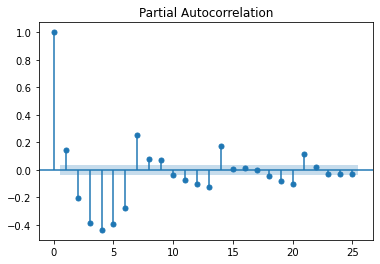

In [26]:
# we plot both ACF and PACF

for df in mod_ls:
    acf = plot_acf(df, lags = 25)
    pacf = plot_pacf(df, lags = 25)

The above plots suggest that our seasonal period for all our games is 7 days, or one week. 

In [28]:
# we establish our parameter variables

p = q = range(0, 2)
d = [0]
pdq = list(itertools.product(p, q, d))
pdqs = [(x[0], x[1], x[2], 7) for x in pdq]




In [29]:
# WARNING, this cell takes 5-10 minutes to run. 


ans_ls = []
for df in mod_ls:
    df = df.dropna()
    ans = []
    for comb in pdq:
        for combs in pdqs:
            mod = SARIMAX(df,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))

    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    ans_df = ans_df.loc[ans_df['aic'].idxmin()].dropna()
    
    ans_ls.append(ans_df)


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-5319.79656103285
ARIMA (0, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-6176.389670036748


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-6479.986959642231


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-6451.418213903276
ARIMA (0, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4247.163411532349


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-4642.3444435617685


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-5045.511598343801


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-4943.864083432336
ARIMA (1, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-5336.908474200677


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-6221.774496212145


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-6503.956441661368


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-6486.281817364894
ARIMA (1, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4423.984487935719


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-5225.276967644128


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-5525.690175757487


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmo

ARIMA (1, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-5496.27616291049
ARIMA (0, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4696.913141339817
ARIMA (0, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-4967.958114681249
ARIMA (0, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-5400.532579794741

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-5290.822200899838
ARIMA (0, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-3544.6004232505165


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-3302.612031470819
ARIMA (0, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-3904.3863062656355


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-3630.8992787290235
ARIMA (1, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4701.869197843429


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-5080.614300088662


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-5453.038669265162


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-5399.050651552809
ARIMA (1, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-3754.1112936887866


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmo

ARIMA (1, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-3979.4245790780997
ARIMA (1, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-4402.098415357474


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-4289.067116257495
ARIMA (0, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4476.71835853458


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-4153.018468239938
ARIMA (0, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-4786.048684583737


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-4548.446965560945
ARIMA (0, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-3094.9277337703184


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-2537.5560502359526


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (0, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-3277.679509826729
ARIMA (0, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-2940.5428825069894


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4482.300935947635
ARIMA (1, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-4236.867482037034

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-4825.223373904328


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-4626.706097204718
ARIMA (1, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-3595.792540344306

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.




ARIMA (1, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-3294.0109910395768


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-3910.392378229014


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-3687.8512870826717
ARIMA (0, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4706.952279980444


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-5460.924754070615


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-6080.917717917214


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-6154.972905313206
ARIMA (0, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-3122.1535392335327


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-2839.1044828285217
ARIMA (0, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-3772.775097494178

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-3617.1973260635095
ARIMA (1, 0, 0) x (0, 0, 0, 7)12 : AIC Calculated =-4763.11409518806
ARIMA (1, 0, 0) x (0, 1, 0, 7)12 : AIC Calculated =-5615.108302606229


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 0, 0, 7)12 : AIC Calculated =-6151.273044792436


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) x (1, 1, 0, 7)12 : AIC Calculated =-6264.987678622509


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (0, 0, 0, 7)12 : AIC Calculated =-3422.902146771339


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (0, 1, 0, 7)12 : AIC Calculated =-3821.0136461355432


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 0, 0, 7)12 : AIC Calculated =-4502.8085134685025


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) x (1, 1, 0, 7)12 : AIC Calculated =-4530.539159435715


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [31]:
for i in range(0, 4):
    print(ans_ls[i])

pdq        (1, 0, 0)
pdqs    (1, 0, 0, 7)
aic         -6503.96
Name: 10, dtype: object
pdq        (1, 0, 0)
pdqs    (1, 0, 0, 7)
aic         -5453.04
Name: 10, dtype: object
pdq        (1, 0, 0)
pdqs    (1, 0, 0, 7)
aic         -4825.22
Name: 10, dtype: object
pdq        (1, 0, 0)
pdqs    (1, 1, 0, 7)
aic         -6264.99
Name: 11, dtype: object


In [37]:
rs = ans_ls[0]
rs.loc['pdq']


(1, 0, 0)

Our optimized models, according to the grid search:

CS:GO --- ARIMA(1,0,1)x(1,0,1,7)

DOTA 2 --- ARIMA(1,0,1)x(1,1,1,7)

ROCKET LEAGUE --- ARIMA(1,0,1)x(1,0,1,7)

TEAM FORTRESS 2 --- ARIMA(1,0,1)x(1,0,1,7)

### c. Model Validation

In [43]:
# we generate validation statistics for our models

csgo_model = SARIMAX(mod_ls[0],
                    order = ans_ls[0].loc['pdq'],
                    seasonal_order = ans_ls[0].loc['pdqs'],
                    enforce_stationarity = False,
                    enforce_invertibility = False)
csgo_output = csgo_model.fit()
(csgo_output.summary())

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              ORLD   No. Observations:                 1827
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 7)   Log Likelihood                3254.978
Date:                           Fri, 22 Jan 2021   AIC                          -6503.956
Time:                                   12:29:26   BIC                          -6487.438
Sample:                               01-04-2016   HQIC                         -6497.862
                                    - 01-03-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1183      0.015     -7.655      0.000      -0.149      -0.088
ar.S.L7        0.7090      0.013     54.842      0.000       0.684       0.734
sigma2         0.0016   3.33e-05     49.079      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):              1094.30
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
dota_model = SARIMAX(mod_ls[1],
                    order = (1,0,1),
                    seasonal_order = (1,1,1,7),
                    enforce_stationarity = False,
                    enforce_invertibility = False)
dota_output = dota_model.fit()
print(dota_output.summary().tables[1])

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4970      0.027     18.103      0.000       0.443       0.551
ma.L1         -0.8617      0.019    -46.350      0.000      -0.898      -0.825
ar.S.L7        0.1607      0.020      8.084      0.000       0.122       0.200
ma.S.L7       -1.0142      0.007   -146.996      0.000      -1.028      -1.001
sigma2         0.0018   4.06e-05     45.574      0.000       0.002       0.002


In [45]:
rl_model = SARIMAX(mod_ls[2],
                    order = (1,0,1),
                    seasonal_order = (1,1,1,7),
                    enforce_stationarity = False,
                    enforce_invertibility = False)
rl_output = rl_model.fit()
print(rl_output.summary().tables[1])

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7094      0.022     32.991      0.000       0.667       0.752
ma.L1         -0.9189      0.015    -60.809      0.000      -0.949      -0.889
ar.S.L7        0.2141      0.020     10.792      0.000       0.175       0.253
ma.S.L7       -0.9722      0.008   -120.663      0.000      -0.988      -0.956
sigma2         0.0034   5.93e-05     57.090      0.000       0.003       0.004


In [46]:
tf_model = SARIMAX(mod_ls[3],
                    order = (1,0,1),
                    seasonal_order = (1,0,1,7),
                    enforce_stationarity = False,
                    enforce_invertibility = False)
tf_output = tf_model.fit()
print(tf_output.summary().tables[1])

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5961      0.016     37.118      0.000       0.565       0.628
ma.L1         -1.1015      0.012    -92.277      0.000      -1.125      -1.078
ar.S.L7        0.9557      0.006    163.436      0.000       0.944       0.967
ma.S.L7       -0.6750      0.015    -45.753      0.000      -0.704      -0.646
sigma2         0.0042      0.000     35.784      0.000       0.004       0.004


In [47]:
models = [csgo_model, dota_model, rl_model, tf_model]
outputs = [csgo_output, dota_output, rl_output, tf_output]

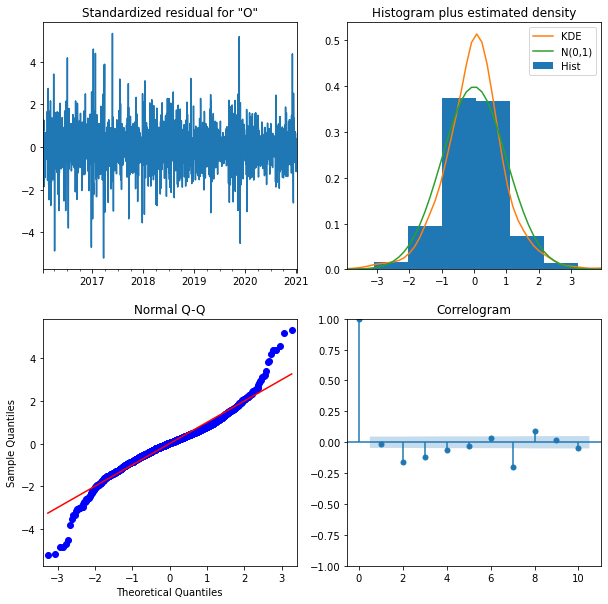

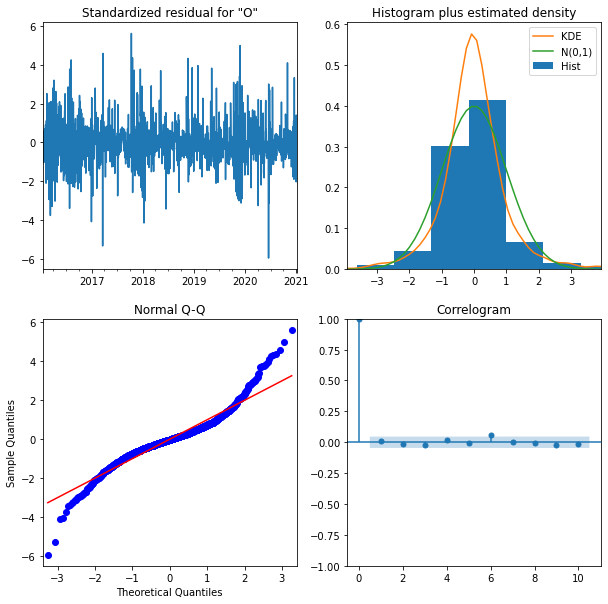

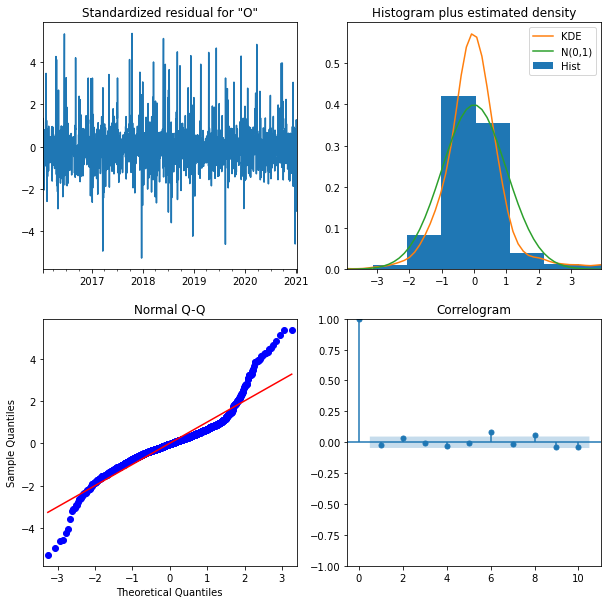

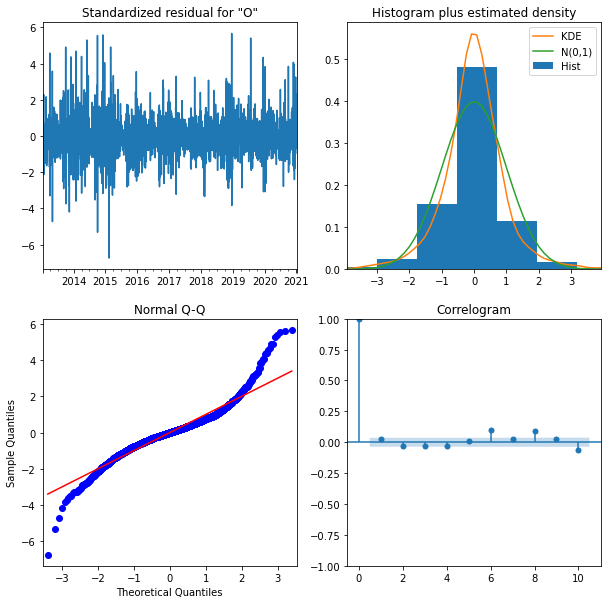

In [48]:
for i, output in enumerate(outputs):
    
    output.plot_diagnostics(figsize = (10, 10))
    

#### Forecasting our Basic Models

We will be forecasting from 2020-12-01 to present, and visualizing the full month.

In [62]:
# we generate our forecasts for each model

predictions = list(map(lambda output: output.get_prediction(start = pd.to_datetime("2020-12-15"), dynamic = False), outputs))
intervals = list(map(lambda prediction: prediction.conf_int(), predictions))

forecasts = list(map(lambda prediction:prediction.predicted_mean.to_frame('predicted_mean'), predictions))


In [63]:
df_plot = ls_w_outliers[0]

df_plot.index = pd.to_datetime(df_plot.index)
df_plot.index

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
               '2020-12-29', '2020-12-30', '2020-12-31', '2021-01-01',
               '2021-01-02', '2021-01-03'],
              dtype='datetime64[ns]', name='time', length=1830, freq=None)

<AxesSubplot:xlabel='time'>

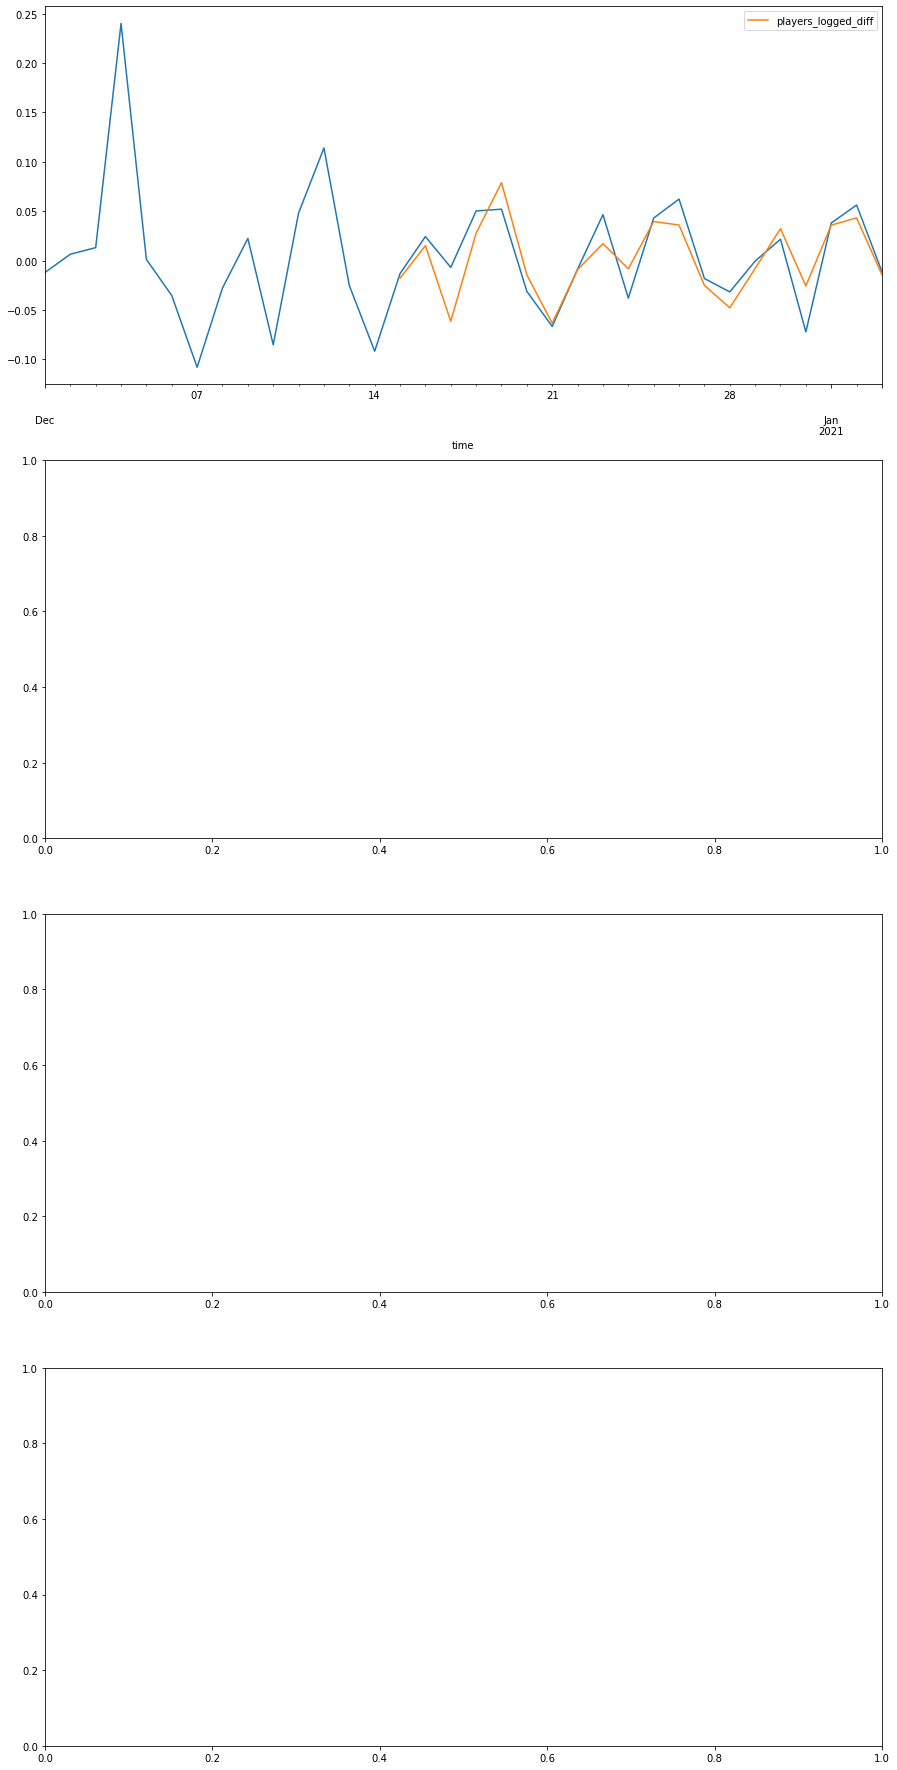

In [71]:
fig, axes = plt.subplots(ncols = 1, nrows = 4, figsize = (15, 32))


#df_plot = pd.DataFrame(ls_w_outliers[i]["2020-12-01":]['players_logged_diff'])
df_plot.loc['2020-12-01':]['players_logged_diff'].plot(label = 'Truth', ax = axes[0])

df_forecast = df_plot[['players_logged_diff']].copy()

df_forecast['players_logged_diff'] = forecasts[0]

df_forecast.loc['2020-12-01':].plot(label = "Forecast", ax = axes[0])

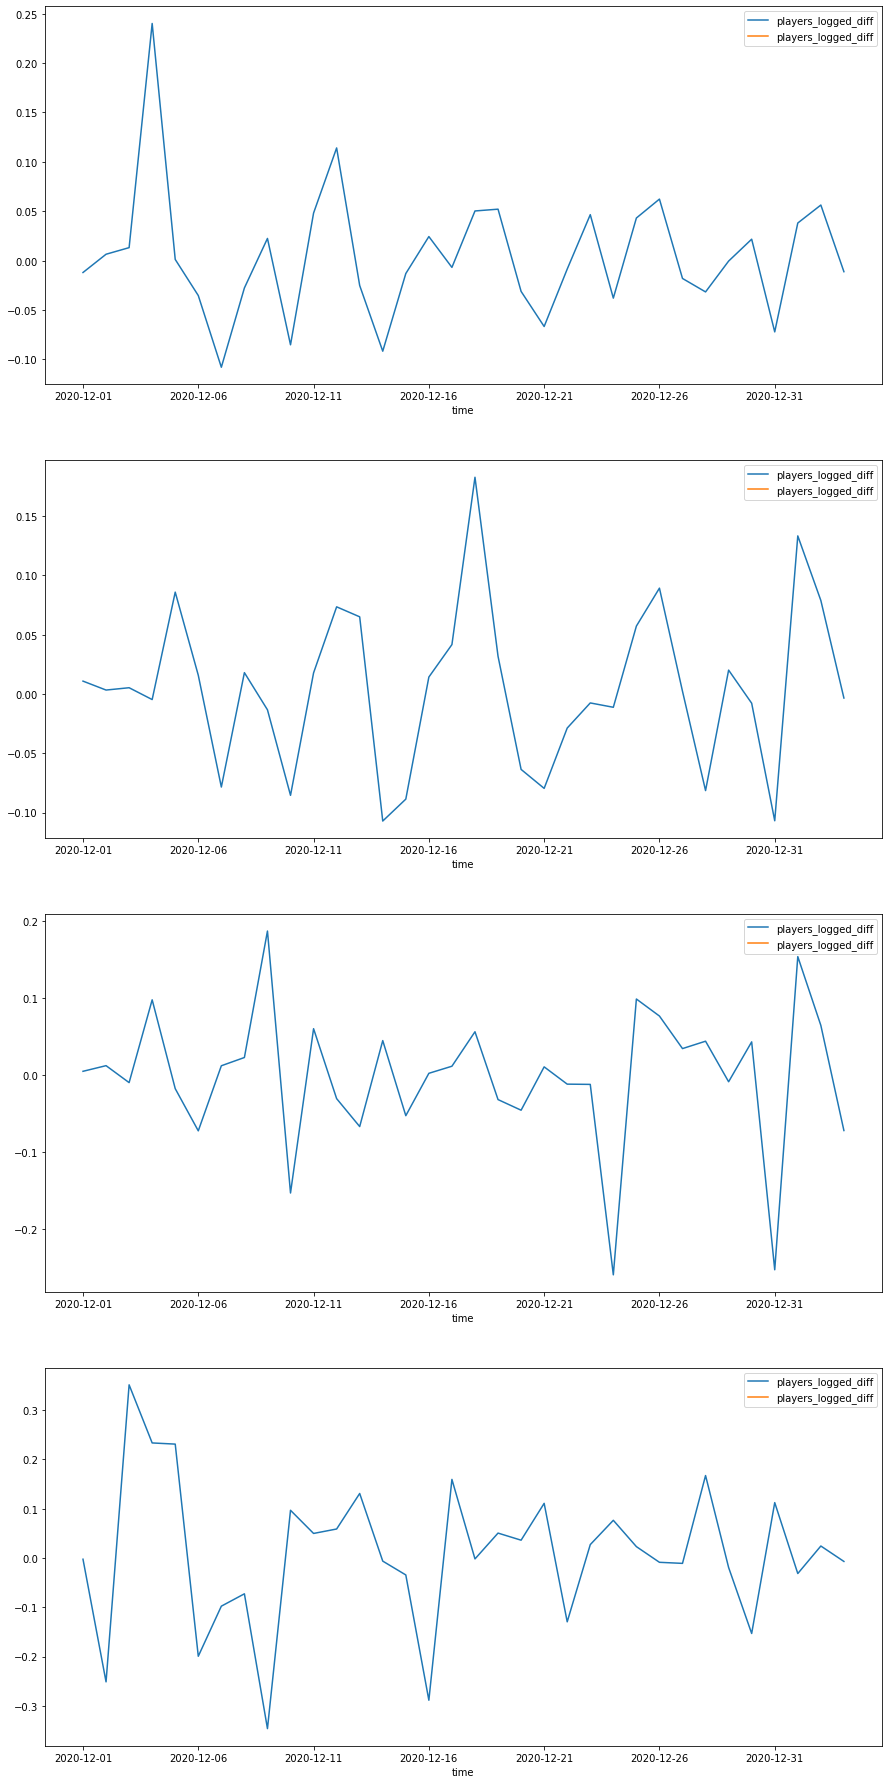

In [50]:
fig, axes = plt.subplots(ncols = 1, nrows = 4, figsize = (15, 32))

for i in range(0, 4):
    df_plot = pd.DataFrame(ls_w_outliers[i]["2020-12-01":]['players_logged_diff'])
    df_plot.plot(label = 'Truth', ax = axes[i])
    
    df_forecast = df_plot.copy()
    
    df_forecast['players_logged_diff'] = forecasts[i]
    
    df_forecast.plot(label = "Forecast", ax = axes[i])
    

In [51]:
for i in range(0, 4):
    forecasted = predictions[i].predicted_mean
    truth = ls_w_outliers[i]["2020-01-01":]['players_logged_diff']
    error = forecasted - truth
    mse = (error ** 2).mean()
    print(mse)

0.0004932624824551214
0.0023935113945104253
0.0067399801869279154
0.0071421259430818175


### Part 1 Conclusions:

We constructed 4 models from the dataframes we have, and summary statistics show that these can all be said to be viable models in predicting the logged differences in player counts. P-values are lower than 0.05, and mean squared error values are also very low, though this is without any support until we can compare these values to those of other models. 

## Part 2: Amalgamized Modelling

The goal in this section of our project is to construct a model from all of our dataframes available. We will hopefully gain a model that is able to predict  for all of our games to an accuracy comparable to the accuracy values gained for individual models, found in part 1 above. 

We can construct this model by simply taking the average of all of our dataframe values. In this case we would be forced to scale all values, so we could feasibly use our % change feature for this process.  

### Taking mean values of dataframes
We are going to be taking the mean of '%_chg_players', but we have to prepare this data first. 
### Preparation

In [38]:
# resetting our dataframes to start fresh from when we trimmed the dataframe dates. 

ls = trimmed_df_list

ls = list(map(lambda df: df.dropna(), ls))

In [39]:
# in order to take the mean, we have to have all our series begin at the same time. We only have to alter team fortress 2

ls[3] = ls[3]["2016-01-01":]

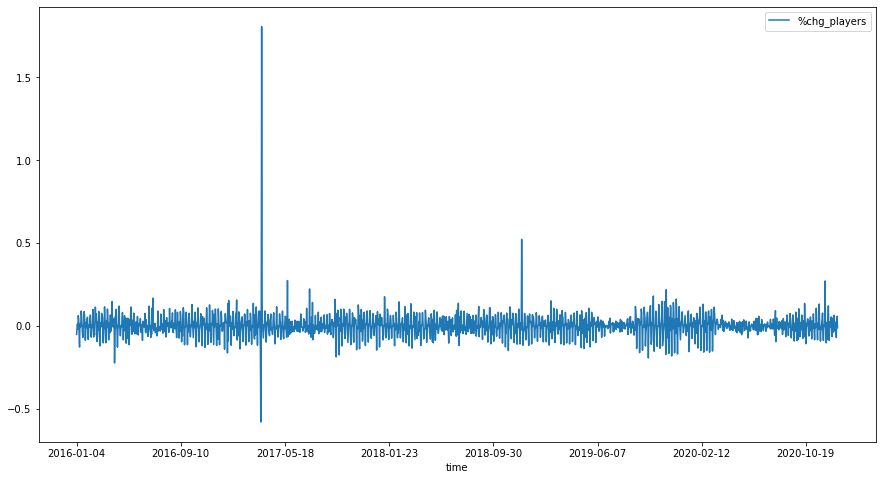

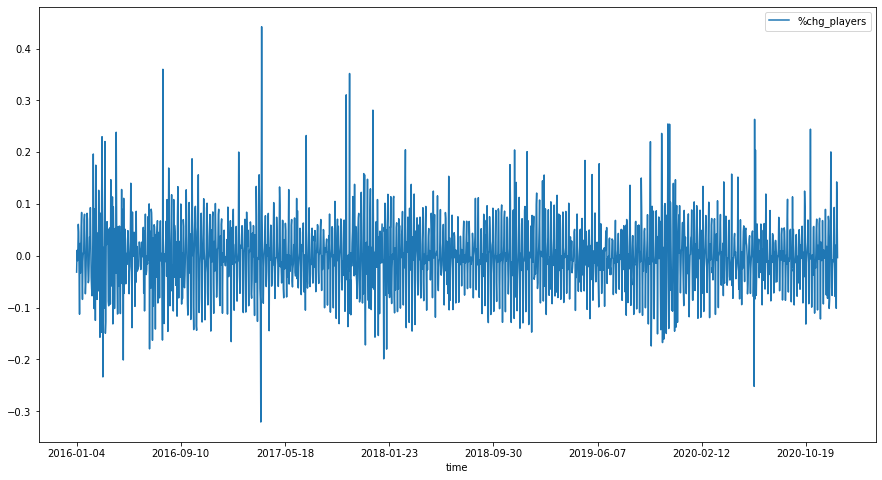

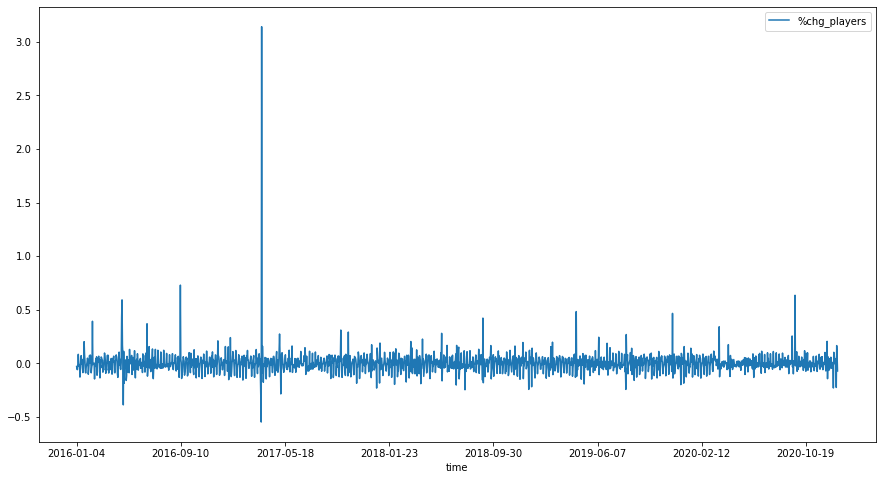

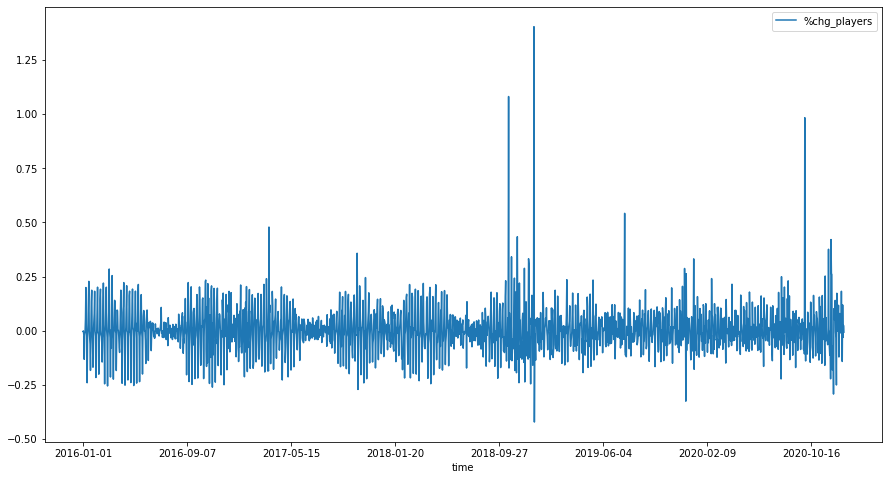

In [40]:
# visualizing this feature
for df in ls:
    
    df_plot = pd.DataFrame(df['%chg_players'])
    df_plot.plot(label = 'Percent Change in Players', figsize = (15,8))


In [72]:
# we should average our data before removing outliers

average_pc = []

for i in range(len(ls[0])):
    pc = '%chg_players'
    average_at_i = np.array([ls[0][pc][i], ls[1][pc][i], ls[2][pc][i], ls[3][pc][i]]).mean() 
    average_pc.append(average_at_i)

df_model = ls[0].copy()
df_model["mean_%chg_players"] = average_pc
df_model = pd.DataFrame(df_model['mean_%chg_players'])

df_model

mean_%chg_players
time                         
2016-01-04          -0.023183
2016-01-05          -0.015296
2016-01-06          -0.030363
2016-01-07          -0.059265
2016-01-08           0.040327
...                       ...
2020-12-30           0.004294
2020-12-31          -0.091255
2021-01-01           0.064991
2021-01-02           0.056055
2021-01-03           0.000705

[1827 rows x 1 columns]

In [83]:
df_mod = (np.array([df[pc] for df in ls]).mean())
df_mod

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



array([        nan,         nan,         nan, ...,  0.07923667,
        0.05780372, -0.02279606])

In [42]:
# while our data is already stationary, we have to address outliers, much like we did before with our logged differences. 

outlier_removed = []

IQR = scipy.stats.iqr(df_model)
mean = df_model.mean()
quantiles = df_model['mean_%chg_players'].quantile([0.25, 0.75])
Q1 = quantiles[0.25]
Q3 = quantiles[0.75]
upper = Q3 + 3*IQR
lower = Q1 - 3*IQR
for val in df_model['mean_%chg_players']:
        if val > upper:
            outlier_removed.append(upper)
        elif val < lower:
            outlier_removed.append(lower)
        else:
            outlier_removed.append(val)
df_model['PCOR'] = outlier_removed

df_model = df_model.drop(columns = ['mean_%chg_players'])

df_model



PCOR
time                
2016-01-04 -0.028664
2016-01-05 -0.014695
2016-01-06 -0.019099
2016-01-07 -0.035620
2016-01-08  0.045607
...              ...
2020-12-30  0.011848
2020-12-31 -0.053178
2021-01-01  0.082226
2021-01-02  0.016156
2021-01-03  0.008673

[1827 rows x 1 columns]

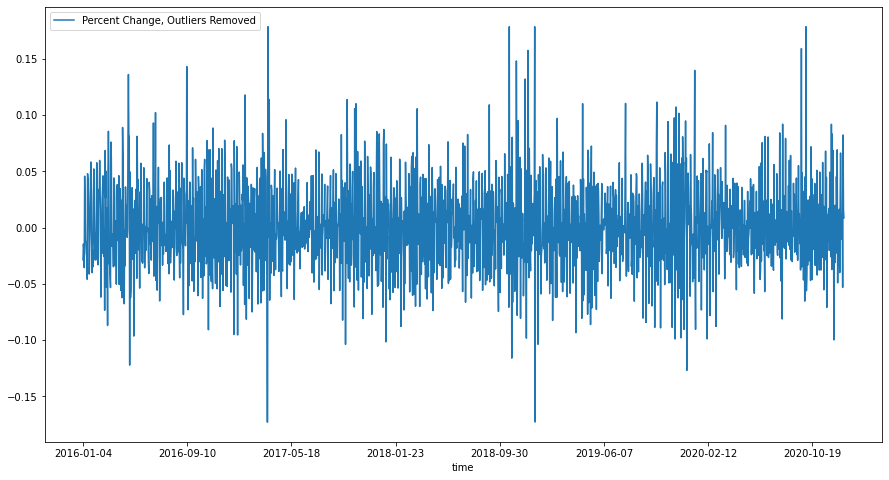

In [43]:
# inspecting how this impacted our visualizations

df_plot = df_model['PCOR']
df_plot.plot(label = "Percent Change, Outliers Removed", figsize = (15, 8))
plt.legend()
plt.show()

Data is ready to be modelled!

As before, we need to first ensure that our seasonality was not affected by our transformations so far. 

### Modelling

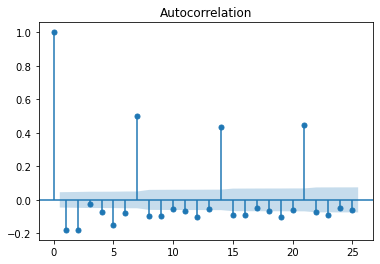

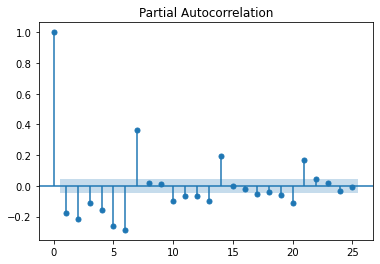

In [44]:
# plotting acf and pacf, showing that our seasonality is retained at s = 7

acf = plot_acf(df_model, lags = 25)
pacf = plot_pacf(df_model, lags = 25)

In [45]:
# defining our parameters for our gridsearch.

p = d = q = range(0, 2)
pdq = list(itertools.product(p, q, d))
pdqs = [(x[0], x[1], x[2], 7) for x in pdq]

In [46]:

models = []
for comb in pdq:
    for combs in pdqs:
        model = SARIMAX(df_model, 
                       order = comb,
                       seasonal_order = combs,
                       enforce_stationarity = False,
                       enforce_invertibility = False)
        output = model.fit()
        models.append([comb, combs, output.aic])
        print('ARIMA {} X {} : AIC Calculated = {}'.format(comb, combs, round(output.aic, 2)))
models_df = pd.DataFrame(models, columns = ['pdq', 'pdqs', 'aic'])
best_model = models_df.loc[models_df['aic'].idxmin()].dropna()
    

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) X (0, 0, 0, 7) : AIC Calculated = -6551.71
ARIMA (0, 0, 0) X (0, 0, 1, 7) : AIC Calculated = -6865.12
ARIMA (0, 0, 0) X (0, 1, 0, 7) : AIC Calculated = -6540.39


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) X (0, 1, 1, 7) : AIC Calculated = -7329.74
ARIMA (0, 0, 0) X (1, 0, 0, 7) : AIC Calculated = -7059.5


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) X (1, 0, 1, 7) : AIC Calculated = -7381.24
ARIMA (0, 0, 0) X (1, 1, 0, 7) : AIC Calculated = -6893.17

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 0) X (1, 1, 1, 7) : AIC Calculated = -7337.5
ARIMA (0, 0, 1) X (0, 0, 0, 7) : AIC Calculated = -6643.29


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmo

ARIMA (0, 0, 1) X (0, 0, 1, 7) : AIC Calculated = -6947.67
ARIMA (0, 0, 1) X (0, 1, 0, 7) : AIC Calculated = -6616.64


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) X (0, 1, 1, 7) : AIC Calculated = -7430.9


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) X (1, 0, 0, 7) : AIC Calculated = -7144.02


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) X (1, 0, 1, 7) : AIC Calculated = -7482.25


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) X (1, 1, 0, 7) : AIC Calculated = -6984.94


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 0, 1) X (1, 1, 1, 7) : AIC Calculated = -7434.69
ARIMA (0, 1, 0) X (0, 0, 0, 7) : AIC Calculated = -4990.92


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) X (0, 0, 1, 7) : AIC Calculated = -5302.63
ARIMA (0, 1, 0) X (0, 1, 0, 7) : AIC Calculated = -4966.88


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) X (0, 1, 1, 7) : AIC Calculated = -5751.83
ARIMA (0, 1, 0) X (1, 0, 0, 7) : AIC Calculated = -5490.13


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) X (1, 0, 1, 7) : AIC Calculated = -5794.19


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) X (1, 1, 0, 7) : AIC Calculated = -5317.61


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 0) X (1, 1, 1, 7) : AIC Calculated = -5766.01


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (0, 0, 0, 7) : AIC Calculated = -6543.56


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (0, 0, 1, 7) : AIC Calculated = -6853.97


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (0, 1, 0, 7) : AIC Calculated = -6522.86


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (0, 1, 1, 7) : AIC Calculated = -7309.61


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (1, 0, 0, 7) : AIC Calculated = -7048.51


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (1, 0, 1, 7) : AIC Calculated = -7360.1


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (1, 1, 0, 7) : AIC Calculated = -6878.86


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (0, 1, 1) X (1, 1, 1, 7) : AIC Calculated = -7315.62
ARIMA (1, 0, 0) X (0, 0, 0, 7) : AIC Calculated = -6605.12


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (0, 0, 1, 7) : AIC Calculated = -6921.61
ARIMA (1, 0, 0) X (0, 1, 0, 7) : AIC Calculated = -6601.89


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (0, 1, 1, 7) : AIC Calculated = -7396.28


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (1, 0, 0, 7) : AIC Calculated = -7113.71


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (1, 0, 1, 7) : AIC Calculated = -7449.08


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (1, 1, 0, 7) : AIC Calculated = -6953.86


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 0) X (1, 1, 1, 7) : AIC Calculated = -7401.61


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (0, 0, 0, 7) : AIC Calculated = -6743.28


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (0, 0, 1, 7) : AIC Calculated = -7032.68


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (0, 1, 0, 7) : AIC Calculated = -6819.22


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (0, 1, 1, 7) : AIC Calculated = -7484.93


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (1, 0, 0, 7) : AIC Calculated = -7219.86


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (1, 0, 1, 7) : AIC Calculated = -7533.6


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (1, 1, 0, 7) : AIC Calculated = -7111.56


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 0, 1) X (1, 1, 1, 7) : AIC Calculated = -7494.12
ARIMA (1, 1, 0) X (0, 0, 0, 7) : AIC Calculated = -5515.94


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) X (0, 0, 1, 7) : AIC Calculated = -5860.89


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) X (0, 1, 0, 7) : AIC Calculated = -5571.2
ARIMA (1, 1, 0) X (0, 1, 1, 7) : AIC Calculated = -6297.69


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) X (1, 0, 0, 7) : AIC Calculated = -6064.35


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) X (1, 0, 1, 7) : AIC Calculated = -6353.05
ARIMA (1, 1, 0) X (1, 1, 0, 7) : AIC Calculated = -5896.47


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 0) X (1, 1, 1, 7) : AIC Calculated = -6307.68


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (0, 0, 0, 7) : AIC Calculated = -6601.08


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (0, 0, 1, 7) : AIC Calculated = -6913.21


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (0, 1, 0, 7) : AIC Calculated = -6584.17


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (0, 1, 1, 7) : AIC Calculated = -7375.86


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (1, 0, 0, 7) : AIC Calculated = -7104.17


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (1, 0, 1, 7) : AIC Calculated = -7428.07


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (1, 1, 0, 7) : AIC Calculated = -6940.18


C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA (1, 1, 1) X (1, 1, 1, 7) : AIC Calculated = -7379.62


In [47]:
print(best_model)

pdq        (1, 0, 1)
pdqs    (1, 0, 1, 7)
aic          -7533.6
Name: 45, dtype: object


### Validation

In [48]:
# we generate summary stats for the model

mean_model = SARIMAX(df_model,
             order = (1,0,1),
             seasonal_order = (1,0,1,7),
             enforce_stationarity = False,
             enforce_invertibility = False)
output = mean_model.fit()
print(output.summary().tables[1])

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\rmcar\Anaconda\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5628      0.030     18.562      0.000       0.503       0.622
ma.L1         -0.8162      0.025    -33.103      0.000      -0.865      -0.768
ar.S.L7        0.9722      0.007    144.732      0.000       0.959       0.985
ma.S.L7       -0.7983      0.017    -47.331      0.000      -0.831      -0.765
sigma2         0.0009   1.64e-05     55.949      0.000       0.001       0.001


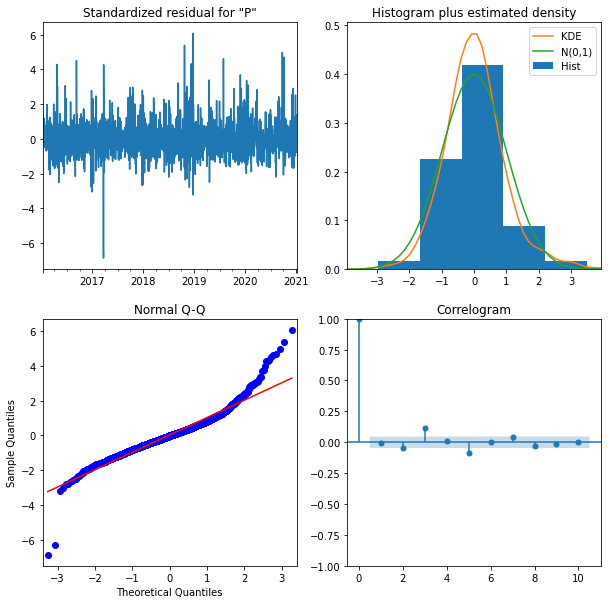

In [49]:
# we visualize validation plots

output.plot_diagnostics(figsize = (10, 10))
plt.show()

#### Forecasting 

We will forecast and calculate the mean squared error for each dataframe, using our constructed model. 

In [50]:
# we generate predictions

pred = output.get_prediction(start = pd.to_datetime("2020-12-01"))
conf_int = pred.conf_int()

forecast = pred.predicted_mean

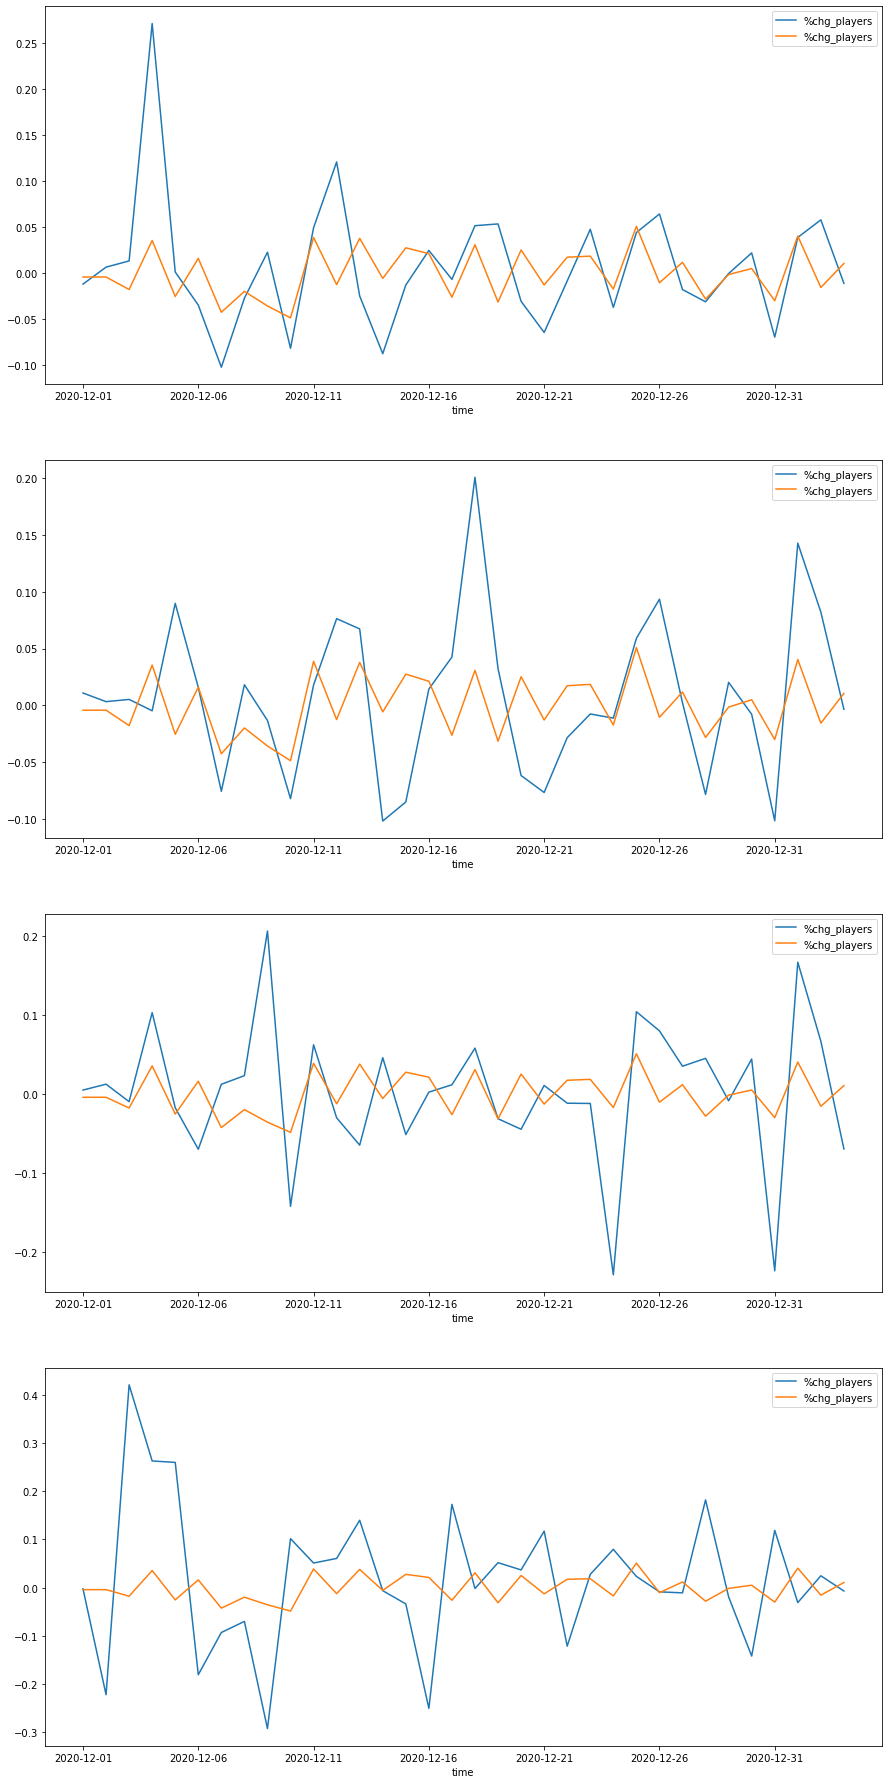

In [51]:
# and visualize the forecasts for each of our dataframes

fig, axes = plt.subplots(ncols = 1, nrows = 4, figsize = (15, 32))

for i in range(0, 4):
    df_plot = pd.DataFrame(ls_w_outliers[i]["2020-12-01":]['%chg_players'])
    df_plot.plot(label = 'Truth', ax = axes[i])
    
    df_forecast = df_plot.copy()
    
    df_forecast['%chg_players'] = forecast
    
    df_forecast.plot(label = "Forecast", ax = axes[i])
    


In [52]:
# finally, we calculate the MSE for each of these forecasts. 

for df in ls_w_outliers:
    forecasted = pred.predicted_mean
    truth = df["2020-12-15":]['%chg_players']
    mse = ((forecasted - truth) ** 2).mean()
    print(mse)

0.001580640049886991
0.0052013008945946855
0.00729545271629181
0.013378305058398909


### Conclusions on Amalgamized Modelling

We constructed one model from the mean change in players for all of our games. This model's summary statistics show that it is more viable than our basic models in part 1, due to the fact that our validation visualizations, namely the QQ plot suggesting that residuals in this model are more normally distributed than for all other models constructed thus far.

This model also has the benefit of being able to be applied to any game. 

In [53]:
# we save all of our constructed models for use in the next notebook

import pickle

models = [csgo_model,
dota_model,
rl_model,
tf_model,
mean_model]

names = ["models/csgo_model.pkl",
"models/dota_model.pkl",
"models/rl_model.pkl",
"models/tf_model.pkl",
"models/mean_model.pkl"]

for i in range(len(models)):
    with open(names[i], 'wb') as file:
        pickle.dump(models[i], file)

In [54]:
# we also save our training and testing dataframes

names = ['csgo_test.csv',
        'dota_test.csv',
        'rl_test.csv',
        'tf_test.csv']

for i in range(len(ls_w_outliers)):
    ls_w_outliers[i].to_csv('data/Test/'+names[i])
    


## Next:

In the next notebook, we will compare our models and describe the pros and cons of each, while also using models to find interesting points in the future. We will also provide our recommendations to those looking to utilize our findings, and conclude with thoughts on how our investigation could have yeilded more insight into these data. 